# Fagerland-Sandvik (2009)の再現

* 黒木 玄
* 2023-11-10

<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#再現用の函数達の定義" data-toc-modified-id="再現用の函数達の定義-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>再現用の函数達の定義</a></span></li><li><span><a href="#再現" data-toc-modified-id="再現-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>再現</a></span><ul class="toc-item"><li><span><a href="#訂正の必要性" data-toc-modified-id="訂正の必要性-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>訂正の必要性</a></span></li><li><span><a href="#訂正版1" data-toc-modified-id="訂正版1-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>訂正版1</a></span></li><li><span><a href="#訂正版2-(ガンマ分布を逆ガンマ分布で置き換えた場合)" data-toc-modified-id="訂正版2-(ガンマ分布を逆ガンマ分布で置き換えた場合)-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>訂正版2 (ガンマ分布を逆ガンマ分布で置き換えた場合)</a></span></li><li><span><a href="#原論文の方法をそのまま再現" data-toc-modified-id="原論文の方法をそのまま再現-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>原論文の方法をそのまま再現</a></span></li></ul></li></ul></div>

論文 Fagerland-Sandvik (2009) https://onlinelibrary.wiley.com/doi/10.1002/sim.3561 の再現をやってみた. 結果は

* https://onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1002%2Fsim.3561&file=sim_3561_sm_SupplMat.pdf

で公開されている. 以下はその論文の説明である.

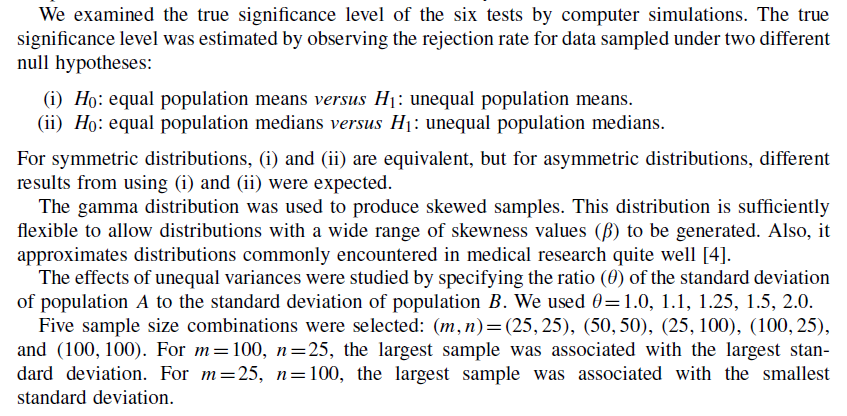

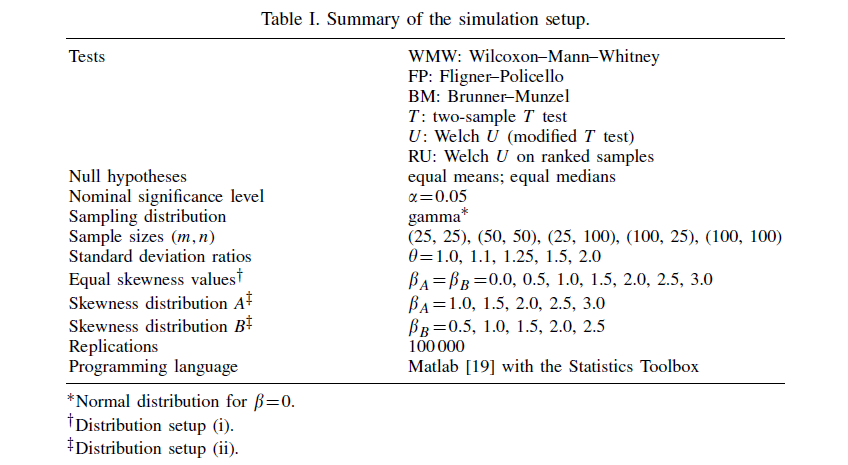

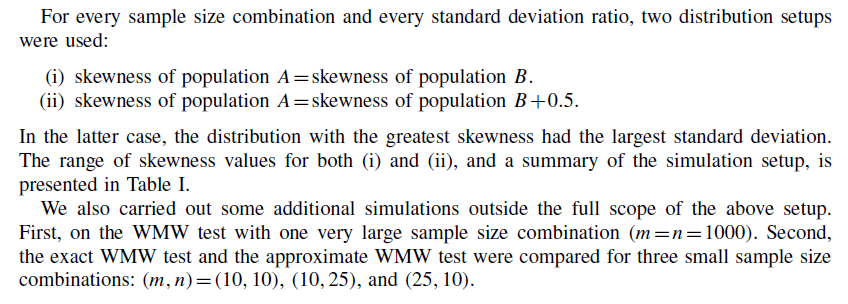

## 再現用の函数達の定義

In [95]:
using Random
Random.seed!(4649373)

using Distributions
using QuadGK
using Roots
using StatsPlots
default(fmt=:png, titlefontsize=10, size=(400, 250))

In [96]:
function winningrate(
        distx::ContinuousUnivariateDistribution,
        disty::ContinuousUnivariateDistribution
    )
    quadgk(y -> cdf(distx, y)*pdf(disty, y), extrema(disty)...)[1]
end

function tieshift(
        distx::ContinuousUnivariateDistribution,
        disty::ContinuousUnivariateDistribution;
        p = 1/2
    )
    find_zero(0.0) do a
        winningrate(distx + a, disty) - p
    end
end

@show distx = Exponential(1)
@show disty = Exponential(1.5)
@show winningrate(distx, disty)
println()
@show tiesh = tieshift(distx, disty)
@show mediansh = median(disty) - median(distx)
@show meansh = mean(disty) - mean(distx)
println()
@show winningrate(distx + tiesh, disty)
@show winningrate(distx + mediansh, disty)
@show winningrate(distx + meansh, disty)
println()
@show median(distx + tiesh)
@show median(distx + mediansh)
@show median(distx + meansh)
@show median(disty)
println()
@show mean(distx + tiesh)
@show mean(distx + mediansh)
@show mean(distx + meansh)
@show mean(disty)
;

distx = Exponential(1) = Exponential{Float64}(θ=1.0)
disty = Exponential(1.5) = Exponential{Float64}(θ=1.5)
winningrate(distx, disty) = 0.6000000000000003

tiesh = tieshift(distx, disty) = 0.27348233139104033
mediansh = median(disty) - median(distx) = 0.3465735902799726
meansh = mean(disty) - mean(distx) = 0.5

winningrate(distx + tiesh, disty) = 0.5
winningrate(distx + mediansh, disty) = 0.47622031634305906
winningrate(distx + meansh, disty) = 0.4299187894696709

median(distx + tiesh) = 0.9666295119509856
median(distx + mediansh) = 1.0397207708399179
median(distx + meansh) = 1.1931471805599454
median(disty) = 1.0397207708399179

mean(distx + tiesh) = 1.2734823313910404
mean(distx + mediansh) = 1.3465735902799727
mean(distx + meansh) = 1.5
mean(disty) = 1.5


In [97]:
using Distributions

@doc raw"""
    brunner_munzel_test(X, Y; p = 1/2)

この函数は数値のベクトルのデータ `X`, `Y` について, 
Brunner-Munzel検定関係の統計量達を計算する. 詳細は以下の通り.

函数 $H(x, y)$ と $\hat{p}$, $H^x_i$, $H^y_j$, $\bar{H}^x$, $\bar{H}^y$ を次のように定める:

```math
\begin{aligned}
&
m = \mathrm{length}(X), \quad
n = \mathrm{length}(Y), \quad
x_i = X[i], \quad
y_j = Y[j],
\\ &
\hat{p} = \frac{1}{mn}\sum_{i=1}^m \sum_{j=1}^n H(x_i, y_j),
\\ &
H(x, y) = \begin{cases} 1 & (x < y) \\ 1/2 & (x = y) \\ 0 & (x > y), \end{cases}
\\ &
H^x_i = \sum_{j=1}^n H(y_j, x_i), \quad
H^y_j = \sum_{i=1}^m H(x_i, y_j),
\\ &
\bar{H}^x = \frac{1}{m} \sum_{i=1}^m H^x_i = n - n\hat{p}, \quad
\bar{H}^y = \frac{1}{n} \sum_{j=1}^n H^y_j = m\hat{p}.
\end{aligned}
```

この函数は以下達の named tuple で返す:

```math
\begin{aligned}
&
\mathrm{phat} = 
\hat{p} = \frac{\bar{H}^y - \bar{H}^x + n}{m + n},
\\ &
\mathrm{sx2} =
\hat{\sigma}_x^2 = \frac{1}{n^2}\frac{1}{m-1}\sum_{i=1}^m (H^x_i - \bar{H}^x)^2,
\\ &
\mathrm{sy2} =
\hat{\sigma}_y^2 = \frac{1}{m^2}\frac{1}{n-1}\sum_{j=1}^n (H^y_j - \bar{H}^y)^2,
\\ &
\mathrm{sehat} = 
\widehat{\mathrm{se}} = \sqrt{\frac{\hat{\sigma}_x^2}{m} + \frac{\hat{\sigma}_y^2}{n}}, 
\\ &
\mathrm{tvalue} = t = \frac{\hat{p} - p}{\widehat{\mathrm{se}}},
\\ &
\mathrm{df} =
\nu = 
\frac
{\left(\hat{\sigma}_x^2/m + \hat{\sigma}_y^2/n\right)^2}
{
\dfrac{\left(\hat{\sigma}_x^2/m\right)^2}{m-1} +
\dfrac{\left(\hat{\sigma}_y^2/n\right)^2}{n-1}
},
\\ &
\mathrm{pvalue} =
2\mathrm{ccdf}(\mathrm{TDist}(\nu), |t|),
\\ &
\mathrm{p} = p.
\end{aligned}
```
"""
function brunner_munzel_test(X, Y; p=1/2)
    m, n = length(X), length(Y)
    phat = mean((x < y) + (x == y)/2 for x in X, y in Y)
    Hbarx = n*(1 - phat)
    Hbary = m*phat
    sx2 = 1/n^2 * 1/(m-1) * sum(x -> (sum((y < x) + (y == x)/2 for y in Y) - Hbarx)^2, X)
    sy2 = 1/m^2 * 1/(n-1) * sum(y -> (sum((x < y) + (x == y)/2 for x in X) - Hbary)^2, Y)
    sehat = √(sx2/m + sy2/n)
    tvalue = (phat - p)/sehat
    df = (sx2/m + sy2/n)^2 / ((sx2/m)^2/(m-1) + (sy2/n)^2/(n-1))
    pvalue = sehat > 0 ? 2ccdf(TDist(df), abs(tvalue)) : phat ≈ p ? 1.0 : 0.0
    (; phat, sehat, tvalue, df, pvalue, p)
end

@doc raw"""
    pvalue_brunner_munzel_test(X, Y; p = 1/2)

この函数はBrunner-Munzel検定のP値 `pvalue` を返す.
"""
pvalue_brunner_munzel_test(X, Y; p=1/2) = brunner_munzel_test(X, Y; p).pvalue

using RCall
@rimport lawstat
X = rand(100)
Y = rand(100)
pvalue_brunner_munzel_test(X, Y), rcopy(lawstat.brunner_munzel_test(X, Y))[:p_value]

(0.10237071161776065, 0.10237071161776079)

In [98]:
X = fill(1, 100)
Y = fill(0, 100)
@show pvalue_brunner_munzel_test(X, Y), rcopy(lawstat.brunner_munzel_test(X, Y))[:p_value]
brunner_munzel_test(X, Y) |> pairs

(pvalue_brunner_munzel_test(X, Y), (rcopy(lawstat.brunner_munzel_test(X, Y)))[:p_value]) = (0.0, NaN)


pairs(::NamedTuple) with 6 entries:
  :phat   => 0.0
  :sehat  => 0.0
  :tvalue => -Inf
  :df     => NaN
  :pvalue => 0.0
  :p      => 0.5

In [99]:
X = fill(0, 100)
Y = fill(1, 100)
@show pvalue_brunner_munzel_test(X, Y), rcopy(lawstat.brunner_munzel_test(X, Y))[:p_value]
brunner_munzel_test(X, Y) |> pairs

(pvalue_brunner_munzel_test(X, Y), (rcopy(lawstat.brunner_munzel_test(X, Y)))[:p_value]) = (0.0, NaN)


pairs(::NamedTuple) with 6 entries:
  :phat   => 1.0
  :sehat  => 0.0
  :tvalue => Inf
  :df     => NaN
  :pvalue => 0.0
  :p      => 0.5

In [100]:
X = zeros(10^3)
Y = zeros(10^3)
@show pvalue_brunner_munzel_test(X, Y), rcopy(lawstat.brunner_munzel_test(X, Y))[:p_value]
brunner_munzel_test(X, Y) |> pairs

(pvalue_brunner_munzel_test(X, Y), (rcopy(lawstat.brunner_munzel_test(X, Y)))[:p_value]) = (1.0, NaN)


pairs(::NamedTuple) with 6 entries:
  :phat   => 0.5
  :sehat  => 0.0
  :tvalue => NaN
  :df     => NaN
  :pvalue => 1.0
  :p      => 0.5

In [101]:
X = zeros(10^3)
Y = zeros(10^3)
Y[1] += eps()
@show pvalue_brunner_munzel_test(X, Y), rcopy(lawstat.brunner_munzel_test(X, Y))[:p_value]
brunner_munzel_test(X, Y) |> pairs

(pvalue_brunner_munzel_test(X, Y), (rcopy(lawstat.brunner_munzel_test(X, Y)))[:p_value]) = (0.3175526601764657, 0.3175526601764127)


pairs(::NamedTuple) with 6 entries:
  :phat   => 0.5005
  :sehat  => 0.0005
  :tvalue => 1.0
  :df     => 999.0
  :pvalue => 0.317553
  :p      => 0.5

In [102]:
@doc brunner_munzel_test

```
brunner_munzel_test(X, Y; p = 1/2)
```

この函数は数値のベクトルのデータ `X`, `Y` について,  Brunner-Munzel検定関係の統計量達を計算する. 詳細は以下の通り.

函数 $H(x, y)$ と $\hat{p}$, $H^x_i$, $H^y_j$, $\bar{H}^x$, $\bar{H}^y$ を次のように定める:

$$
\begin{aligned}
&
m = \mathrm{length}(X), \quad
n = \mathrm{length}(Y), \quad
x_i = X[i], \quad
y_j = Y[j],
\\ &
\hat{p} = \frac{1}{mn}\sum_{i=1}^m \sum_{j=1}^n H(x_i, y_j),
\\ &
H(x, y) = \begin{cases} 1 & (x < y) \\ 1/2 & (x = y) \\ 0 & (x > y), \end{cases}
\\ &
H^x_i = \sum_{j=1}^n H(y_j, x_i), \quad
H^y_j = \sum_{i=1}^m H(x_i, y_j),
\\ &
\bar{H}^x = \frac{1}{m} \sum_{i=1}^m H^x_i = n - n\hat{p}, \quad
\bar{H}^y = \frac{1}{n} \sum_{j=1}^n H^y_j = m\hat{p}.
\end{aligned}
$$

この函数は以下達の named tuple で返す:

$$
\begin{aligned}
&
\mathrm{phat} = 
\hat{p} = \frac{\bar{H}^y - \bar{H}^x + n}{m + n},
\\ &
\mathrm{sx2} =
\hat{\sigma}_x^2 = \frac{1}{n^2}\frac{1}{m-1}\sum_{i=1}^m (H^x_i - \bar{H}^x)^2,
\\ &
\mathrm{sy2} =
\hat{\sigma}_y^2 = \frac{1}{m^2}\frac{1}{n-1}\sum_{j=1}^n (H^y_j - \bar{H}^y)^2,
\\ &
\mathrm{sehat} = 
\widehat{\mathrm{se}} = \sqrt{\frac{\hat{\sigma}_x^2}{m} + \frac{\hat{\sigma}_y^2}{n}}, 
\\ &
\mathrm{tvalue} = t = \frac{\hat{p} - p}{\widehat{\mathrm{se}}},
\\ &
\mathrm{df} =
\nu = 
\frac
{\left(\hat{\sigma}_x^2/m + \hat{\sigma}_y^2/n\right)^2}
{
\dfrac{\left(\hat{\sigma}_x^2/m\right)^2}{m-1} +
\dfrac{\left(\hat{\sigma}_y^2/n\right)^2}{n-1}
},
\\ &
\mathrm{pvalue} =
2\mathrm{ccdf}(\mathrm{TDist}(\nu), |t|),
\\ &
\mathrm{p} = p.
\end{aligned}
$$


In [103]:
function mann_whitney_u_test(X, Y; correct=true)
    m, n = length(X), length(Y)
    phat = mean((x < y) + (x == y)/2 for x in X, y in Y)
    sehat = √((m+n+1)/(12m*n))
    zvalue = (phat - 1/2)/sehat
    correction = correct/(2m*n*sehat)
    pvalue = 2ccdf(Normal(), max(0, abs(zvalue) - correction))
    (; phat, sehat, zvalue, pvalue)
end

pvalue_mann_whitney_u_test(X, Y; correct=true) = mann_whitney_u_test(X, Y; correct).pvalue

using HypothesisTests
X = randn(100)
Y = randn(100)
pvalue_mann_whitney_u_test(X, Y), pvalue(ApproximateMannWhitneyUTest(X, Y))

(0.04990007292443201, 0.04990007292443193)

In [104]:
function student_t_test(X, Y; μ = 0.0)
    m, X̄, SX2 = length(X), mean(X), var(X)
    n, Ȳ, SY2 = length(Y), mean(Y), var(Y)
    S2 = ((m-1)*SX2 + (n-1)*SY2) / (m+n-2)
    sehat2 = S2 * (1/m + 1/n)
    tvalue = (X̄ - Ȳ - μ) / √sehat2
    df = m + n - 2
    pvalue = 2ccdf(TDist(df), abs(tvalue))
    (; pvalue, tvalue, sehat2, df)
end

pvalue_student_t_test(X, Y; μ = 0.0) = student_t_test(X, Y; μ).pvalue

using HypothesisTests
X = randn(100)
Y = randn(100)
pvalue_student_t_test(X, Y), pvalue(EqualVarianceTTest(X, Y))

(0.4389806931272048, 0.4389806931272048)

In [105]:
function welch_t_test(X, Y; μ = 0.0)
    m, X̄, SX2 = length(X), mean(X), var(X)
    n, Ȳ, SY2 = length(Y), mean(Y), var(Y)
    sehat2 = SX2/m + SY2/n
    tvalue = (X̄ - Ȳ - μ) / √sehat2
    df = sehat2^2 / ((SX2/m)^2/(m-1) + (SY2/n)^2/(n-1))
    pvalue = 2ccdf(TDist(df), abs(tvalue))
    (; pvalue, tvalue, sehat2, df)
end

pvalue_welch_t_test(X, Y; μ = 0.0) =welch_t_test(X, Y; μ).pvalue

using HypothesisTests
X = randn(100)
Y = randn(100)
pvalue_welch_t_test(X, Y), pvalue(UnequalVarianceTTest(X, Y))

(0.7219945156946428, 0.7219945156946428)

In [106]:
"""
gammadist(σ, β)

returns the gamma distribution with standard deviation `σ` and skewness `β`.
"""
gammadist(σ, β) = β == 0 ? Normal(0, σ) : Gamma(4/β^2, β*σ/2)

gam = gammadist.(1:5, 2:2:10)
[std.(gam), skewness.(gam), kurtosis.(gam), shape.(gam)]

4-element Vector{Vector{Float64}}:
 [1.0, 2.0, 3.0, 4.0, 5.0]
 [2.0, 4.0, 6.0, 8.0, 10.0]
 [6.0, 24.0, 54.0, 96.0, 150.0]
 [1.0, 0.25, 0.1111111111111111, 0.0625, 0.04]

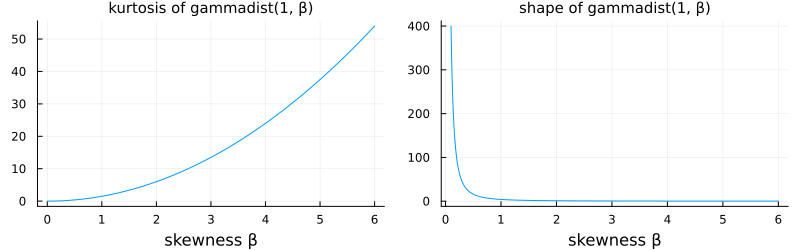

In [107]:
β = range(eps(), 6, 1000)
P = plot(β, β -> kurtosis(gammadist(1, β)); label="")
plot!(xguide="skewness β", yguide="", title="kurtosis of gammadist(1, β)")

β = range(0.1, 6, 1000)
Q = plot(β, β -> shape(gammadist(1, β)); label="")
plot!(xguide="skewness β", yguide="", title="shape of gammadist(1, β)")

plot(P, Q; size=(800, 250))
plot!(bottommargin=4Plots.mm)

In [108]:
@doc gammadist

gammadist(σ, β)

returns the gamma distribution with standard deviation `σ` and skewness `β`.


In [109]:
"""
inversegammadist(σ, β)

returns the inverse gamma distribution with standard deviation `σ` and skewness `β`.
"""
function inversegammadist(σ, β)
    β == 0 && return Normal(0, σ)
    α = 3 + 8/β^2 + 4/β * √(1 + 4/β^2)
    θ = σ * (α - 1) * √(α - 2)
    InverseGamma(α, θ)
end

igam = inversegammadist.(1:5, 2:2:10)
[std.(igam), skewness.(igam), kurtosis.(igam), shape.(igam)]

4-element Vector{Vector{Float64}}:
 [0.9999999999999999, 2.0, 3.0, 3.9999999999999996, 5.0]
 [2.0, 4.0, 6.0, 7.999999999999998, 10.0]
 [9.134446499564898, 72.54101966249682, NaN, NaN, NaN]
 [7.82842712474619, 4.618033988749895, 3.9249505911485287, 3.6403882032022077, 3.487921561087423]

In [110]:
c = find_zero(β -> 3 + 8/β^2 + 4/β * √(1 + 4/β^2) - 4.0, 3.0)

5.65685424949238

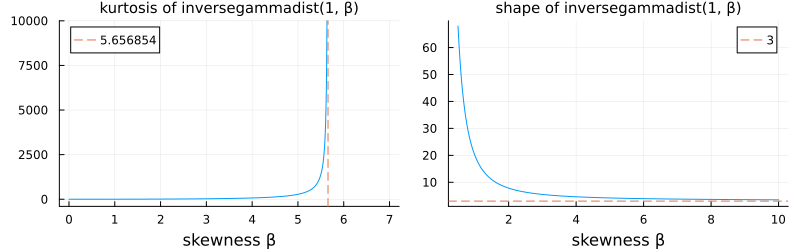

In [111]:
β = range(eps(), 7, 1000)
P = plot(β, β -> kurtosis(inversegammadist(1, β)); label="")
vline!([c]; label="$(round(c; digits=6))", ls=:dash)
plot!(xtick=0:10, ylim=(-400, 10000))
plot!(xguide="skewness β", yguide="", title="kurtosis of inversegammadist(1, β)")

β = range(0.5, 10, 1000)
Q = plot(β, β -> shape(inversegammadist(1, β)); label="")
hline!([3]; label="3", ls=:dash)
plot!(xguide="skewness β", yguide="", title="shape of inversegammadist(1, β)")

plot(P, Q; size=(800, 250))
plot!(bottommargin=4Plots.mm)

In [112]:
@doc inversegammadist

inversegammadist(σ, β)

returns the inverse gamma distribution with standard deviation `σ` and skewness `β`.


In [127]:
undefarray(T::Type, n...) = Array{T}(undef, n...)
undefarray(n...) = undefarray(Float64, n...)
ECDF(A, x) = count(≤(x), A) / length(A)

list_skewness = Tuple((β, β) for β in 0:0.5:3)
list_skewness2 = Tuple((β, β-0.5) for β in 1:0.5:3)
list_stdratio = reverse((1.0, 1.1, 1.25, 1.5, 2.0))

rd(x) = round(100x; digits=1)

function print_sim(;
        list_skewness=list_skewness,
        list_stdratio = list_stdratio,
        distfunc = gammadist,
        distfuncx = distfunc,
        distfuncy = distfunc,
        α = 0.05,
        L = 10^5,
        m = 25,
        n = 25,
        shifttype = :auto,
        correct = true,
    )
    
    nx = length(list_skewness)
    ny = length(list_stdratio)
    # `er` stands for "true alpha Error Rate".
    er_wmw = undefarray(nx, ny)
    er_bm = undefarray(nx, ny)
    er_st = undefarray(nx, ny)
    er_we = undefarray(nx, ny)
    
    for (i, (β1, β2)) in enumerate(list_skewness), (j, σ) in enumerate(list_stdratio)
        distx = distfuncx(σ, β1)
        disty = distfuncy(1, β2)
        (; pval_wmw, pval_bm, pval_st, pval_we) = sim(distx, disty, m, n; shifttype, correct, L)
        er_wmw[i, j] = ECDF(pval_wmw, α)
        er_bm[i, j] = ECDF(pval_bm, α)
        er_st[i, j] = ECDF(pval_st, α)
        er_we[i, j] = ECDF(pval_we, α)
    end
    
    println("skewness = ", list_skewness)
    println("stdratio = ", list_stdratio)
    println("distx = $distfuncx,  disty = $distfuncy, m = $m,  n = $n,  shifttype = $shifttype")
    println()
    println("Wilcoxon-Mann-Whitney:"); Base.print_matrix(stdout, rd.(er_wmw'))
    println("\n\nBrunner-Munzel:"); Base.print_matrix(stdout, rd.(er_bm'))
    println("\n\nStudent t:"); Base.print_matrix(stdout, rd.(er_st'))
    println("\n\nWelch t:"); Base.print_matrix(stdout, rd.(er_we'))
    println("\n")
end

function sim(distx, disty, m, n; shifttype=:mean, correct=true, L=10^5)
    meansh = mean(disty) - mean(distx)
    mediansh = median(disty) - median(distx)
    tiesh = tieshift(distx, disty)
    if shifttype == :mean
        distx_sh = distx + meansh
    elseif shifttype == :median
        distx_sh = distx + mediansh
    elseif shifttype == :tie || shifttype == :auto
        distx_sh = distx + tiesh
    else
        distx_sh = distx
    end
    
    pval_wmw = undefarray(L)
    pval_bm = undefarray(L)
    pval_st = undefarray(L)
    pval_we = undefarray(L)
    nth = Threads.nthreads()
    Xtmp = [undefarray(m) for _ in 1:nth]
    Ytmp = [undefarray(n) for _ in 1:nth]
    Threads.@threads for i in 1:L
        tid = Threads.threadid()
        X = rand!(distx_sh, Xtmp[tid])
        Y = rand!(disty, Ytmp[tid])
        pval_wmw[i] = pvalue_mann_whitney_u_test(X, Y; correct)
        pval_bm[i] = pvalue_brunner_munzel_test(X, Y)
        if shifttype == :auto
            @. X = X - tiesh + meansh
        end
        pval_st[i] = pvalue_student_t_test(X, Y)
        pval_we[i] = pvalue_welch_t_test(X, Y)
    end
    
    (; pval_wmw, pval_bm, pval_st, pval_we)
end

function print_sim(distx, disty, m, n; shifttype=:mean, L=10^5, α=0.05)
    (; pval_wmw, pval_bm, pval_st, pval_we) = sim(distx, disty, m, n; shifttype, L)
    er_wmw = ECDF(pval_wmw, α)
    er_bm = ECDF(pval_bm, α)
    er_st = ECDF(pval_st, α)
    er_we = ECDF(pval_we, α)
    println("distx = $distx")
    println("disty = $disty")
    println("m = $m,  n = $n,  shifttype = $shifttype")
    println()
    println("Wilcoxon-Mann-Whitney: ", rd(er_wmw), "%")
    println("Brunner-Munzel:        ", rd(er_bm), "%")
    println("Student t:             ", rd(er_st), "%")
    println("Welch t:               ", rd(er_we), "%")
    println()
    
end

print_sim (generic function with 2 methods)

In [15]:
@time print_sim(gammadist(1.1, 3), gammadist(1, 3), 1000, 1000; shifttype=:mean, L=10^4)

distx = Gamma{Float64}(α=0.4444444444444444, θ=1.6500000000000001)
disty = Gamma{Float64}(α=0.4444444444444444, θ=1.5)
m = 1000,  n = 1000,  shifttype = mean

Wilcoxon-Mann-Whitney: 99.0
Brunner-Munzel:        98.9
Student t:             4.9
Welch t:               4.9

  6.281947 seconds (477.88 k allocations: 35.176 MiB, 46.65% compilation time: <1% of which was recompilation)


In [16]:
@time print_sim(gammadist(1.1, 3), gammadist(1, 3), 1000, 1000; shifttype=:median, L=10^4)

distx = Gamma{Float64}(α=0.4444444444444444, θ=1.6500000000000001)
disty = Gamma{Float64}(α=0.4444444444444444, θ=1.5)
m = 1000,  n = 1000,  shifttype = median

Wilcoxon-Mann-Whitney: 40.1
Brunner-Munzel:        39.6
Student t:             13.4
Welch t:               13.4

  5.813514 seconds (112.73 k allocations: 11.785 MiB)


In [17]:
@time print_sim(gammadist(1.1, 3), gammadist(1, 3), 1000, 1000; shifttype=:tie, L=10^4)

distx = Gamma{Float64}(α=0.4444444444444444, θ=1.6500000000000001)
disty = Gamma{Float64}(α=0.4444444444444444, θ=1.5)
m = 1000,  n = 1000,  shifttype = tie

Wilcoxon-Mann-Whitney: 5.0
Brunner-Munzel:        5.0
Student t:             23.8
Welch t:               23.8

  5.857024 seconds (109.47 k allocations: 10.826 MiB)


## 再現

### 訂正の必要性

論文 Fagerland-Sandvik (2009) は不適切な比較をしていたので, その訂正版を以下で作成した.

__解説:__ どこが不適切なのか.  論文 Fagerland-Sandvik (2009) では, 2つのテスト用の仮想的な母集団分布を適当にシフトして

* 母平均を等しくした場合

と

* 母中央値を等しくした場合

を扱っている. 

「2つの母平均は等しい」はStudentの $t$ 検定とWelchの $t$ 検定(Welchの $t$ 検定は Fagerland-Sandvik (2009) でがWelch U test (modified T test)と呼ばれている)の帰無仮説なので, それらのアルファエラー率を調べるときには「母平均を等しくした場合」を見る必要がある.

しかし, 「2つの母中央値は等しい」はWilcoxon-Mann-WhitneyのU検定やBrunner-Munzel検定の帰無仮説ではない.  だから, それらのアルファエラー率を調べるときには「母中央値を等しくした場合」を見てはいけない.  それらの検定が中央値に関する検定でないことは論文でも指摘されているのだが, なぜかアルファエラー率を調べるために「2つの母中央値を等しくした場合」のみを計算してしまっている.

WMW検定の検定統計量Uの定義は, 無作為抽出された2つの標本 $[X_1,\ldots,X_m]$, $[Y_1,\ldots,Y_n]$ について

$$
U = \sum_{i=1}^m \sum_{j=1}^n h(X_i, Y_j), \quad
h(x, y) = \begin{cases}
1 & (x < y) \\
1/2 & (x = y) \\
0 & (x > y)
\end{cases}
$$

であり, WMW検定では $U$ と $mn/n$ の差の絶対値が十分に大きいときに帰無仮説が棄却される.

BM検定の検定統計量 $\hat{p}$ は

$$
\hat{p} = \frac{U}{mn} = \frac{1}{mn}\sum_{i=1}^m \sum_{j=1}^n h(X_i, Y_j)
$$

であり, BM検定では $\hat{p}$ と $1/2$ の差の絶対値が十分に大きいときに帰無仮説が棄却される

WMW検定とBM検定の検定統計量は本質的に同じであると考えられる. 

WMW検定とBM検定の本質的な違いは検定統計量の分散の見積もり方の違いである.

検定統計量 $\hat{p}$ は $Y$ 側の母勝率

$$
p = P(X_1 < Y_1) + P(X_1 = Y_1)/2
$$

の不偏一致推定量になっている. 

そして, 検定統計量 $\hat{p}$ の分散の推定値は, WMW検定でもBM検定でも, $m,n\to\infty$ で $0$ に近付く.

だから, もしも母勝率 $p$ が $1/2$ に等しくないならば, WMW検定でもBM検定でも, $m,n\to\infty$ で帰無仮説が棄却される確率は $1$ に近付く.

母中央値が等しいことと母勝率が $1/2$ に等しいことは同値ではない(これも Fagerland-Sandvik (2009) で指摘されている).

だから, 母中央値が等しいという条件の下で, WMW検定やBM検定達のアルファエラー率を計算すると, 標本サイズを大きくするほど名目有意水準の $5 \%$ からかけ離れた値になって行くことになる.

Fagerland-Sandvik (2009)は実際にそういう結果を得ている.

そういう結果が得られることは当然なのに Fagerland-Sandvik (2009) では以下のように述べてしまっている. これはひどくミスリーディングである!

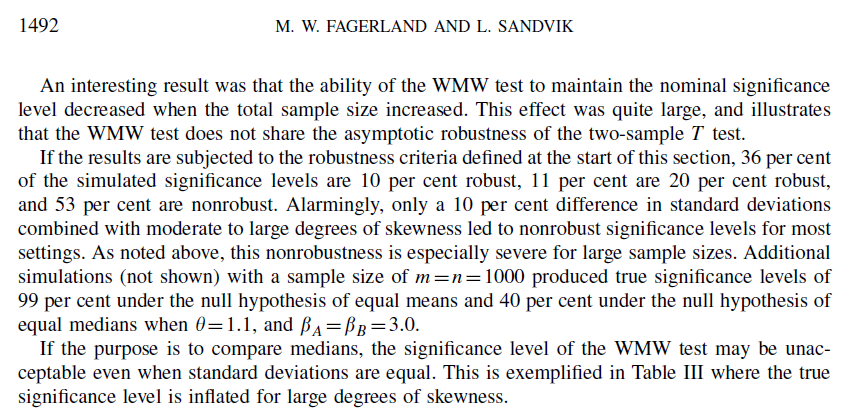

__翻訳:__

>興味深い結果は, 総標本サイズが大きくなると, 名目有意水準を維持するWMW検定の能力が低下することであった.  この効果は極めて大きく, WMW検定が2標本T検定(Studentのt検定)の漸近的頑健性を共有しないことを示す.

>この結果をこのセクションの最初に定義した頑健性の基準にかけると, シミュレートされた有意水準の36%が10%頑強性を持ち, 11%が20%頑強性を持ち, 53%は頑強ではない.  驚くべきことに, 標準偏差の差が10％しかないことと歪度の度合いが中程度以上であることが合わさって, ほとんどの設定で頑強でない有意水準になった.  上述したように, この非頑強性は標本サイズが大きい場合に特に深刻である.  m = n = 1000の標本サイズでの追加シミュレーション(資料に載っていない)では, 母平均が等しいという帰無仮説のもとでは99%, 母中央値が等しいという帰無仮説のもとでは40%の実質有意水準が得られた($\theta = 1.1$ (標準偏差の比が $1.1$), $\beta_A = \beta_B = 3.0$ (母歪度はどちらも $3.0$))。

>もしも目的が中央値の比較であれば, たとえ標準偏差が等しい場合であっても, WMW検定の有意水準は許容できないだろう.  これは、歪度の度合いが大きいと真の有意水準が高くなることはテーブルⅢで例証されています。

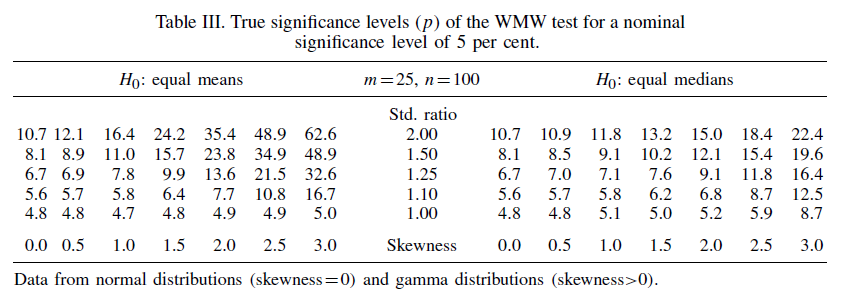

WMW検定の検定統計量を見れば, WMW検定を母平均の差や母中央値の差の検定として使えないことは自明なのに, わざわざこのように述べるのはおかしい.

この点の強調はWMW検定やBM検定について著しく不利な印象を読者に与えることになる.

フェアな比較をするためには

* 母勝率を $1/2$ にした場合

でWMW検定やBM検定のアルファエラー率を計算してみる必要がある.

__テーブルⅢの再現__

In [77]:
@time print_sim(; m=25, n=100, shifttype=:mean)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 25,  n = 100,  shifttype = mean

Wilcoxon-Mann-Whitney:
 10.8  12.0  16.6  24.6  35.7  49.1  62.5
  8.1   8.9  11.0  15.6  23.5  35.3  48.7
  6.8   6.9   7.8   9.7  13.8  21.6  32.6
  5.6   5.8   6.0   6.1   7.5  10.7  16.6
  5.0   5.0   4.9   4.9   4.9   4.8   4.9

Brunner-Munzel:
 5.1  5.8  8.5  13.4  20.7  30.6  42.3
 5.0  5.5  6.6   9.6  14.3  21.9  31.8
 5.2  5.3  5.8   7.0   9.4  14.0  21.0
 5.2  5.3  5.5   5.4   6.1   7.8  11.2
 5.2  5.2  5.2   5.2   5.1   5.1   5.2

Student t:
 18.1  18.0  18.2  18.3  18.4  18.8  18.8
 12.2  12.1  12.1  12.1  11.9  12.1  12.0
  8.6   8.3   8.6   8.4   8.3   8.2   8.0
  6.5   6.5   6.5   6.1   6.1   5.9   5.8
  5.1   5.0   5.0   4.9   4.8   4.7   4.6

Welch t:
 5.1  5.1  5.7  6.5  7.1  8.5  9.4
 4.9  5.2  5.5  6.1  6.8  8.0  8.9
 5.1  5.1  5.5  5.9  6.6  7.4  8.2
 5.1  5.

上の結果は論文 Fagerland-Sandvik (2009) のテーブルⅢの等平均の場合を再現できている.

In [79]:
@time print_sim(; m=25, n=100, shifttype=:median)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 25,  n = 100,  shifttype = median

Wilcoxon-Mann-Whitney:
 10.8  11.0  11.1  12.3  13.8  15.8  17.9
  8.3   8.5   8.6   9.4  10.6  12.8  15.3
  6.7   6.6   6.9   7.2   8.0   9.4  12.0
  5.5   5.6   5.6   5.9   6.2   7.0   8.1
  4.9   4.9   4.8   4.8   4.9   4.8   4.8

Brunner-Munzel:
 5.2  5.2  5.3  5.8  6.5  7.4  8.5
 5.1  5.2  5.3  5.6  6.1  7.2  8.4
 5.1  5.1  5.3  5.3  5.6  6.2  7.4
 5.1  5.2  5.1  5.3  5.4  5.6  6.0
 5.2  5.2  5.1  5.1  5.1  5.1  5.2

Student t:
 18.2  18.6  20.3  23.1  26.6  30.1  32.6
 12.0  12.5  12.8  13.8  14.9  16.1  17.0
  8.6   8.5   8.8   9.0   9.3   9.5   9.8
  6.3   6.3   6.4   6.5   6.5   6.4   6.4
  5.0   5.0   4.9   4.8   4.8   4.6   4.7

Welch t:
 5.1  5.2  5.3  5.8  6.6  7.3  7.5
 4.9  5.1  5.0  5.1  5.2  5.3  5.3
 5.0  4.9  5.1  5.0  5.1  5.1  5.3
 4.9  5.0  5.2  5.4  5.5  

上の結果は論文 Fagerland-Sandvik (2009) のテーブルⅢの党中央値の場合を再現できて__いない.__

それは当然である. 標準偏差と歪度が等しい2つのガンマ分布は一致し, 2つの同じ分布の標本にWilcoxon-Mann-Whitney検定を適用すると帰無仮説が棄却される確率は名目有意水準に一致する

In [83]:
@time print_sim(; m=25, n=100, shifttype=:median, list_skewness=list_skewness2)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 25,  n = 100,  shifttype = median

Wilcoxon-Mann-Whitney:
 10.6  10.3  10.5  10.8  11.0
  7.9   7.4   7.4   6.7   6.5
  6.5   6.1   5.9   6.1   7.9
  5.6   5.4   5.6   6.3   8.5
  5.0   4.9   5.1   6.6   8.8

Brunner-Munzel:
 5.3  5.2  5.3  5.5   5.6
 5.2  5.1  5.2  5.2   5.9
 5.4  5.3  5.7  6.6   9.7
 5.6  5.8  6.5  8.2  12.4
 5.7  6.1  6.9  9.7  14.1

Student t:
 24.0  27.7  31.0  34.3  35.5
 15.6  17.2  18.9  19.4  18.9
 11.3  11.7  12.0  11.7  11.5
  8.3   8.5   8.3   7.7   7.1
  6.5   6.2   5.8   5.5   5.0

Welch t:
 6.7  7.5  8.4  9.1  8.9
 6.0  6.1  6.4  6.2  5.7
 5.8  5.6  5.4  5.1  5.0
 5.7  5.4  5.1  4.9  5.3
 5.5  5.1  5.0  5.2  5.9

  6.687324 seconds (25.93 M allocations: 2.063 GiB, 4.66% gc time)


上の結果を見れば, もしも目的が中央値の比較であれば, たとえ標準偏差が等しい場合であっても, WMW検定やBM検定を使うべきではないことがわかる.

しかし, これはすでに述べたように自明であり, この点を強調することはミスリーディングである.

WMW検定やBM検定は, それらの検定統計量を見れば, 「母勝率が $1/2$ である」という帰無仮説の検定だとみなされるべきであることがわかる.

__フェアな比較__

In [80]:
@time print_sim(; m=25, n=100)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 25,  n = 100,  shifttype = auto

Wilcoxon-Mann-Whitney:
 10.7  10.8  10.7  10.8  11.0  11.1  11.0
  8.4   8.3   8.3   8.5   8.6   8.8   8.7
  6.7   6.8   6.9   7.0   7.0   7.0   7.0
  5.5   5.7   5.6   5.8   5.8   5.8   5.9
  4.9   4.8   5.0   4.9   4.9   4.9   4.9

Brunner-Munzel:
 5.3  5.1  5.2  5.1  5.2  5.3  5.2
 5.1  5.1  5.1  5.2  5.1  5.3  5.2
 5.1  5.2  5.3  5.2  5.2  5.1  5.2
 5.1  5.2  5.1  5.2  5.2  5.2  5.2
 5.2  5.2  5.3  5.2  5.2  5.1  5.2

Student t:
 18.0  18.2  18.1  18.2  18.5  18.6  18.8
 12.2  12.1  12.2  12.1  12.1  12.2  12.1
  8.6   8.7   8.6   8.6   8.4   8.1   8.0
  6.4   6.4   6.3   6.4   6.2   6.1   6.0
  5.0   5.0   4.9   4.9   4.6   4.7   4.7

Welch t:
 5.1  5.2  5.7  6.3  7.1  8.3  9.6
 5.0  5.1  5.6  6.2  6.8  7.8  8.9
 5.0  5.3  5.5  6.0  6.6  7.4  8.0
 5.0  5.1  5.3  5.8  6.4  7.

この結果を見ると,

* 「母勝率は $1/2$ である」という帰無仮説の検定ではWMW検定よりもBM検定を使うべきである.
* 「2つの母平均は等しい」という帰無仮説の検定ではStudentのt検定よりもWelchのt検定を使うべきである.

ということがわかる.  ただし,

* 例外的に「2つの母分散は等しい」という条件を2つの母集団分布が満たしていることが事前に何らかの理由で分かっている場合には例外的に, 「2つの母平均は等しい」という帰無仮説の検定ではWelchのt検定よりもStudentのt検定を使った方がよい.

これは非常に例外的な場合である.  Welchのt検定の非頑強性は標本サイズが十分に大きくないことによって生じており, 下の方のセルでの計算のように標本サイズを大きくすると緩和される.

Welchのt検定の頑強性の基礎は中心極限定理による標本平均の分布の正規分布近似である. 母歪度の絶対値が大きいと標本平均の分布の正規分布近似の精度を上げるためにはより大きな標本サイズが必要になる. 

中心極限定理によって標本平均の分布が十分に正規分布近似されていると期待される場合には, Studentの $t$ 検定のような脆弱な検定法は使わずに, Welchの $t$ 検定を使った方がよいだろう.

In [85]:
@time print_sim(; m=100, n=400, L=10^4)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 100,  n = 400,  shifttype = auto

Wilcoxon-Mann-Whitney:
 10.8  10.8  10.9  10.9  11.7  11.5  11.2
  8.4   9.0   8.6   9.0   8.5   8.8   8.8
  7.0   7.0   6.9   6.7   6.7   7.2   7.2
  5.7   5.5   5.4   6.0   5.6   5.8   5.7
  5.0   5.0   5.0   4.9   5.1   4.9   5.0

Brunner-Munzel:
 5.0  4.9  5.0  5.1  5.3  5.4  5.4
 5.0  5.2  5.3  5.1  4.9  5.0  4.9
 5.4  5.2  5.1  4.8  4.5  5.2  5.1
 5.2  4.8  4.5  5.3  4.8  4.9  4.9
 5.1  5.0  5.0  4.8  5.2  5.0  5.0

Student t:
 17.7  17.5  17.6  17.2  18.9  18.5  18.0
 12.2  12.4  12.3  12.1  12.0  12.0  12.5
  9.1   8.9   8.6   8.5   8.0   8.1   8.4
  6.3   6.1   6.2   6.3   5.9   7.0   6.6
  5.0   5.0   4.9   5.1   4.8   4.8   5.1

Welch t:
 5.0  4.9  5.1  5.2  6.0  6.2  6.8
 5.0  5.3  5.4  5.3  5.3  6.0  6.8
 5.3  5.6  4.9  5.3  5.2  5.6  6.2
 5.0  4.8  4.9  5.1  5.1  6

In [126]:
distx = gammadist(2, 3)
disty = gammadist(1, 3)
@show tieshift(distx, disty)
@show mean(disty) - mean(distx)
@show median(disty) - median(distx);

tieshift(distx, disty) = -0.15274477941518558
mean(disty) - mean(distx) = -0.6666666666666666
median(disty) - median(distx) = -0.2711292144816104


ついでに述べておくと, 以下に引用する論文 Fagerland-Sandvik (2009) におけるWMW検定の基本に関する説明も間違っている.

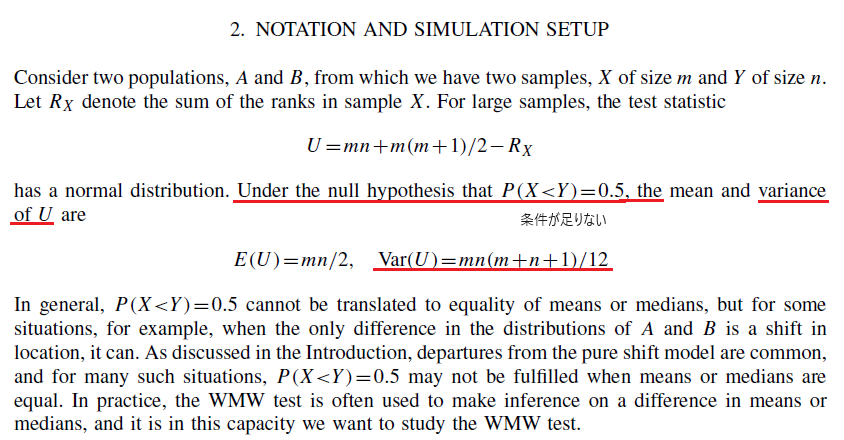

$U$ 統計量の分散が $mn(m+n+1)/12$ になることを示すためには, $P(X<Y)=1/2$ を仮定するだけでは足りず, $X$ と $Y$ の分布が互いに等しいという極めて強い条件を仮定する必要がある.  このことがWMW検定の脆弱性の主原因になっている.

Brunner-Munzel検定では「$X$ と $Y$ の分布が互いに等しい」という仮定を大幅に緩めてある種の中心極限定理による正規分布近似だけを仮定して, 検定統計量 $\hat{p}=mnU$ の分散を推定している.

### 訂正版1

以下では, WMW検定とBM検定については母集団分布の適当なシフトによって「母勝率を $1/2$ にした場合」でアルファエラー率を計算し, Studentのt検定とWelchのt検定については母集団分布の適当なシフトによって「母平均が等しい場合」でアルファエラー率を計算している(シフトタイプが自動(auto)の場合).

In [18]:
@time print_sim(; m=25, n=25, list_skewness=list_skewness)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 25,  n = 25,  shifttype = auto

Wilcoxon-Mann-Whitney:
 5.7  5.7  5.6  5.6  5.7  5.6  5.7
 5.0  5.1  5.1  5.1  5.2  5.1  5.1
 4.8  4.9  4.8  4.8  4.8  4.9  4.9
 4.7  4.7  4.6  4.7  4.7  4.8  4.8
 4.7  4.7  4.9  4.7  4.8  4.6  4.7

Brunner-Munzel:
 5.2  5.3  5.2  5.2  5.1  5.1  5.2
 5.1  5.3  5.2  5.2  5.3  5.2  5.1
 5.2  5.2  5.2  5.2  5.1  5.3  5.3
 5.2  5.2  5.1  5.2  5.2  5.3  5.2
 5.2  5.2  5.4  5.2  5.3  5.1  5.1

Student t:
 5.2  5.4  5.4  5.7  6.0  6.4  7.2
 5.1  5.2  5.2  5.2  5.3  5.4  5.4
 5.0  5.1  4.9  5.0  4.9  4.9  4.9
 4.9  5.0  4.9  4.9  4.7  4.8  4.6
 4.9  5.0  5.0  4.8  4.8  4.4  4.4

Welch t:
 5.0  5.2  5.2  5.5  5.9  6.3  7.0
 5.0  5.1  5.1  5.1  5.2  5.3  5.2
 4.9  5.0  4.8  4.9  4.7  4.7  4.7
 4.9  5.0  4.8  4.8  4.6  4.5  4.4
 4.9  4.9  4.9  4.8  4.6  4.2  4.2

  8.096170 seconds (60.74 M 

In [19]:
@time print_sim(; m=50, n=50, list_skewness=list_skewness)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 50,  n = 50,  shifttype = auto

Wilcoxon-Mann-Whitney:
 5.8  5.8  5.8  5.9  6.0  6.1  6.0
 5.3  5.3  5.2  5.3  5.3  5.5  5.4
 5.1  4.9  5.0  5.0  5.1  5.0  5.3
 5.0  4.8  4.9  4.9  5.0  4.9  5.0
 5.0  4.9  5.1  4.9  4.9  4.9  5.0

Brunner-Munzel:
 5.0  5.0  5.0  5.1  5.1  5.2  5.1
 5.1  5.1  5.0  5.1  5.1  5.2  5.1
 5.2  5.0  5.1  5.1  5.1  5.0  5.2
 5.1  5.0  5.1  5.1  5.2  5.1  5.2
 5.2  5.0  5.3  5.0  5.1  5.1  5.2

Student t:
 5.1  5.1  5.2  5.3  5.6  6.0  6.3
 5.1  5.0  5.1  5.2  5.2  5.3  5.4
 5.0  5.0  4.9  5.0  5.0  4.9  5.0
 5.0  4.8  5.0  4.9  4.9  4.8  4.8
 5.1  5.0  5.1  4.9  4.9  4.8  4.8

Welch t:
 5.0  5.0  5.1  5.2  5.5  5.9  6.2
 5.0  4.9  5.1  5.2  5.1  5.3  5.3
 5.0  5.0  4.9  4.9  4.9  4.8  5.0
 5.0  4.8  5.0  4.9  4.8  4.8  4.7
 5.1  5.0  5.1  4.9  4.8  4.8  4.7

 11.279718 seconds (55.77 M 

In [20]:
@time print_sim(; m=25, n=100, list_skewness=list_skewness)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 25,  n = 100,  shifttype = auto

Wilcoxon-Mann-Whitney:
 10.7  10.7  10.9  11.0  11.0  11.0  11.0
  8.4   8.3   8.4   8.6   8.4   8.7   8.4
  6.9   6.8   6.8   6.8   6.9   6.9   6.9
  5.7   5.7   5.7   5.7   5.8   5.9   5.8
  4.9   4.8   4.8   4.9   4.9   4.9   4.9

Brunner-Munzel:
 5.2  5.1  5.2  5.2  5.1  5.2  5.2
 5.2  5.2  5.2  5.3  5.0  5.3  5.0
 5.3  5.2  5.3  5.1  5.1  5.1  5.1
 5.2  5.3  5.2  5.2  5.2  5.2  5.1
 5.2  5.1  5.2  5.2  5.2  5.2  5.1

Student t:
 18.0  18.2  18.0  18.3  18.4  18.5  18.8
 12.1  12.1  12.2  12.1  11.9  11.9  11.8
  8.7   8.7   8.7   8.4   8.3   8.1   8.1
  6.5   6.4   6.4   6.3   6.2   6.2   6.0
  5.0   4.9   4.9   4.9   4.9   4.7   4.7

Welch t:
 5.0  5.0  5.7  6.4  7.3  8.2  9.5
 5.1  5.2  5.6  6.2  6.9  7.6  8.7
 5.1  5.3  5.5  5.8  6.6  7.4  8.1
 5.1  5.2  5.4  5.8  6.3  6.

In [21]:
@time print_sim(; m=100, n=25, list_skewness=list_skewness)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 100,  n = 25,  shifttype = auto

Wilcoxon-Mann-Whitney:
 1.5  1.5  1.5  1.5  1.5  1.6  1.7
 2.5  2.4  2.4  2.4  2.3  2.3  2.4
 3.4  3.4  3.4  3.3  3.3  3.3  3.3
 4.3  4.1  4.2  4.1  4.2  4.1  4.0
 4.8  4.9  4.8  5.0  4.8  4.8  4.9

Brunner-Munzel:
 5.1  5.1  5.1  5.1  5.0  5.1  5.4
 5.2  5.1  5.1  5.1  5.0  5.1  5.0
 5.1  5.2  5.2  5.2  5.2  5.2  5.1
 5.2  5.1  5.2  5.1  5.3  5.2  5.1
 5.1  5.2  5.1  5.3  5.1  5.0  5.2

Student t:
 0.5  0.4  0.5  0.7  0.9  1.0  1.2
 1.4  1.4  1.4  1.4  1.6  1.7  2.0
 2.6  2.5  2.6  2.5  2.6  2.7  2.8
 3.8  3.7  3.8  3.6  3.8  3.7  3.6
 5.0  5.0  4.9  4.9  4.8  4.7  4.7

Welch t:
 5.0  5.0  4.9  4.9  4.8  4.9  4.7
 5.1  4.9  5.1  5.2  5.2  5.2  5.3
 5.0  5.1  5.2  5.4  5.7  5.9  6.3
 5.0  5.1  5.3  5.5  6.1  6.4  6.8
 4.9  5.1  5.3  5.7  6.2  6.5  7.4

 12.299431 seconds (55.22 M

In [22]:
@time print_sim(; m=100, n=100, list_skewness=list_skewness)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 100,  n = 100,  shifttype = auto

Wilcoxon-Mann-Whitney:
 6.0  5.9  5.8  5.9  6.0  6.0  6.1
 5.4  5.3  5.3  5.4  5.6  5.5  5.4
 5.1  5.0  5.1  5.0  5.2  5.1  5.2
 5.0  5.0  5.1  4.9  4.9  5.0  5.0
 5.0  5.0  4.9  5.0  4.9  4.8  4.9

Brunner-Munzel:
 5.1  5.0  5.0  4.9  5.1  5.1  5.1
 5.1  5.0  5.0  5.1  5.2  5.1  5.0
 5.0  5.0  5.0  5.0  5.1  5.0  5.1
 5.0  5.0  5.2  5.0  5.0  5.0  5.1
 5.1  5.0  5.0  5.0  5.0  4.9  5.0

Student t:
 5.0  5.2  5.1  5.3  5.4  5.6  5.7
 5.1  5.0  4.9  5.1  5.1  5.1  5.3
 5.0  4.9  5.1  5.0  5.0  4.9  4.9
 5.0  5.0  5.0  5.0  4.9  4.8  4.8
 5.0  4.9  4.9  4.9  4.9  4.9  4.9

Welch t:
 5.0  5.1  5.1  5.2  5.3  5.5  5.7
 5.0  5.0  4.9  5.0  5.0  5.1  5.3
 5.0  4.9  5.1  5.0  5.0  4.9  4.8
 5.0  5.0  5.0  5.0  4.9  4.8  4.8
 5.0  4.9  4.9  4.9  4.9  4.9  4.8

 30.151709 seconds (55.75 

In [23]:
@time print_sim(; m=25, n=25, list_skewness=list_skewness2)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 25,  n = 25,  shifttype = auto

Wilcoxon-Mann-Whitney:
 5.4  5.4  5.4  5.3  5.1
 5.0  5.0  4.9  4.7  4.9
 4.8  4.8  4.7  4.7  4.7
 4.8  4.8  4.7  4.8  4.7
 4.6  4.7  4.8  4.9  4.9

Brunner-Munzel:
 5.1  5.1  5.2  5.2  5.1
 5.2  5.3  5.2  5.1  5.3
 5.2  5.3  5.2  5.1  5.2
 5.3  5.2  5.1  5.3  5.1
 5.2  5.2  5.3  5.2  5.2

Student t:
 5.3  5.8  6.3  6.6  7.1
 5.2  5.3  5.5  5.5  5.7
 5.1  5.0  5.1  5.0  5.0
 5.1  4.9  4.8  4.8  4.5
 4.9  4.9  4.9  4.7  4.5

Welch t:
 5.2  5.7  6.2  6.4  6.9
 5.2  5.2  5.3  5.4  5.5
 5.1  4.9  5.0  4.9  4.8
 5.0  4.8  4.7  4.7  4.3
 4.8  4.8  4.8  4.5  4.3

  4.213164 seconds (40.03 M allocations: 2.142 GiB, 7.32% gc time, 3.98% compilation time)


In [24]:
@time print_sim(; m=50, n=50, list_skewness=list_skewness2)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 50,  n = 50,  shifttype = auto

Wilcoxon-Mann-Whitney:
 5.7  5.7  5.6  5.5  5.5
 5.2  5.3  5.3  5.1  4.9
 5.0  5.0  5.1  4.9  4.9
 4.9  4.9  4.9  4.9  5.1
 4.9  5.1  5.0  5.3  5.1

Brunner-Munzel:
 5.0  5.1  5.0  5.1  5.1
 5.0  5.2  5.2  5.0  5.0
 5.1  5.1  5.2  5.0  5.0
 5.1  5.1  5.0  5.0  5.1
 5.1  5.2  5.1  5.2  5.1

Student t:
 5.2  5.4  5.6  6.0  6.4
 5.1  5.3  5.3  5.3  5.4
 5.1  5.0  5.1  5.0  5.0
 5.0  5.0  5.0  4.9  4.8
 4.9  5.1  4.9  5.0  4.7

Welch t:
 5.2  5.3  5.5  5.9  6.3
 5.0  5.3  5.3  5.2  5.4
 5.1  5.0  5.0  5.0  4.9
 5.0  4.9  5.0  4.8  4.8
 4.9  5.1  4.9  4.9  4.6

  8.057711 seconds (39.84 M allocations: 2.127 GiB, 4.40% gc time)


In [25]:
@time print_sim(; m=25, n=100, list_skewness=list_skewness2)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 25,  n = 100,  shifttype = auto

Wilcoxon-Mann-Whitney:
 10.3  10.4  9.9  9.8  9.3
  7.9   7.8  7.2  6.9  6.2
  6.4   6.1  5.6  5.2  5.0
  5.3   5.0  4.6  4.2  4.0
  4.5   4.1  3.9  3.7  3.4

Brunner-Munzel:
 5.0  5.2  5.1  5.2  5.0
 5.2  5.3  5.1  5.1  5.1
 5.2  5.3  5.2  5.2  5.4
 5.2  5.1  5.2  5.1  5.2
 5.1  5.0  5.0  5.2  5.1

Student t:
 17.9  18.3  18.3  18.5  18.8
 12.2  12.1  12.0  11.8  11.5
  8.5   8.5   8.2   8.1   8.1
  6.3   6.3   6.1   5.9   5.8
  4.8   4.8   4.7   4.6   4.4

Welch t:
 5.5  6.4  7.2  8.3  9.6
 5.6  6.2  6.9  7.8  8.5
 5.5  6.1  6.7  7.4  8.4
 5.4  5.9  6.4  7.1  7.9
 5.2  5.5  6.2  6.7  7.4

  8.090839 seconds (40.24 M allocations: 2.239 GiB, 4.26% gc time)


In [26]:
@time print_sim(; m=100, n=25, list_skewness=list_skewness2)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 100,  n = 25,  shifttype = auto

Wilcoxon-Mann-Whitney:
 1.7  1.7  1.8  1.9  2.1
 2.8  2.8  3.0  3.4  3.6
 3.6  3.9  4.3  4.7  5.1
 4.5  4.8  5.3  5.7  6.1
 5.3  5.6  6.0  6.6  6.9

Brunner-Munzel:
 5.1  5.0  5.1  5.1  5.1
 5.2  5.1  5.2  5.3  5.2
 5.1  5.2  5.3  5.2  5.1
 5.0  5.1  5.2  5.2  5.1
 5.2  5.2  5.1  5.2  5.2

Student t:
 0.6  0.7  0.8  1.1  1.2
 1.5  1.5  1.7  1.8  2.0
 2.6  2.7  2.8  2.9  2.9
 3.8  3.9  3.8  3.9  3.9
 5.0  5.0  5.0  5.0  4.9

Welch t:
 5.0  4.8  4.9  4.9  4.8
 5.0  5.0  5.3  5.3  5.3
 4.9  5.2  5.4  5.6  5.9
 5.0  5.2  5.5  5.8  6.3
 5.2  5.3  5.6  6.2  6.7

  8.515832 seconds (39.45 M allocations: 2.016 GiB, 4.20% gc time)


In [27]:
@time print_sim(; m=100, n=100, list_skewness=list_skewness2)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 100,  n = 100,  shifttype = auto

Wilcoxon-Mann-Whitney:
 5.8  5.6  5.6  5.5  5.6
 5.2  5.3  5.1  5.1  5.0
 4.9  4.9  5.1  5.1  5.1
 5.0  5.1  4.9  5.1  5.1
 4.8  5.0  5.0  5.2  5.3

Brunner-Munzel:
 5.0  5.0  5.0  5.0  5.1
 5.0  5.1  5.0  5.1  5.0
 4.9  4.9  5.1  5.1  5.1
 5.1  5.1  5.0  5.0  5.0
 4.9  5.1  5.0  5.1  5.1

Student t:
 5.2  5.1  5.3  5.5  5.7
 5.2  5.2  5.3  5.2  5.1
 4.9  4.9  5.1  5.0  5.1
 5.0  5.0  5.0  4.9  5.0
 4.8  4.9  5.0  5.0  4.9

Welch t:
 5.2  5.1  5.3  5.5  5.7
 5.1  5.2  5.2  5.2  5.1
 4.9  4.9  5.1  5.0  5.1
 5.0  5.0  5.0  4.9  4.9
 4.8  4.9  5.0  5.0  4.9

 21.607582 seconds (39.83 M allocations: 2.123 GiB, 1.72% gc time)


上で使われた最も歪度が大きな場合(歪度は $3$)のガンマ分布をプロットしてみよう. 

In [28]:
gammadist(1, 3)

Gamma{Float64}(α=0.4444444444444444, θ=1.5)

In [29]:
@show skewness(gammadist(1, 3))
@show kurtosis(gammadist(1, 3));

skewness(gammadist(1, 3)) = 3.0
kurtosis(gammadist(1, 3)) = 13.5


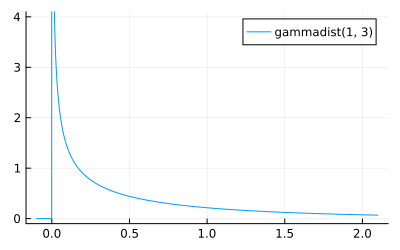

In [92]:
plot(gammadist(1, 3), -0.1, 2.1; label="gammadist(1, 3)", ylim=(-0.1, 4.1))

このように, 歪度が $3$ のガンマ分布は左端で密度函数の値が無限大になるような分布になっている.  これはあまりにも特殊な状況であるようにも思われる.  そこで, 次の節ではガンマ分布を逆ガンマ分布で置き換えた場合も扱ってみよう.

In [31]:
inversegammadist(1, 3)

InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)


In [32]:
@show skewness(inversegammadist(1, 3))
@show kurtosis(inversegammadist(1, 3));

skewness(inversegammadist(1, 3)) = 3.0
kurtosis(inversegammadist(1, 3)) = 26.57534780374744


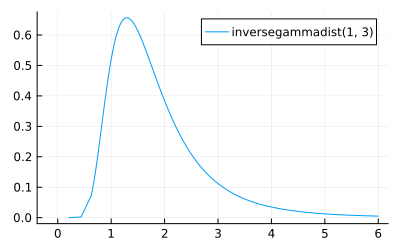

In [93]:
plot(inversegammadist(1, 3), -0.2, 6; label="inversegammadist(1, 3)")

### 訂正版2 (ガンマ分布を逆ガンマ分布で置き換えた場合)

In [34]:
@time print_sim(; m=25, n=25, list_skewness=list_skewness, distfunc=inversegammadist)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = inversegammadist,  disty = inversegammadist, m = 25,  n = 25,  shifttype = auto

Wilcoxon-Mann-Whitney:
 5.4  5.6  5.7  5.6  5.3  5.6  5.5
 5.1  5.0  5.2  4.9  5.0  5.0  5.0
 4.7  4.8  4.8  4.8  4.9  4.7  4.8
 4.8  4.8  4.6  4.8  4.6  4.8  4.8
 4.6  4.7  4.8  4.7  4.8  4.6  4.7

Brunner-Munzel:
 5.0  5.2  5.3  5.3  5.0  5.3  5.2
 5.3  5.2  5.3  5.1  5.2  5.2  5.3
 5.1  5.2  5.2  5.2  5.3  5.1  5.2
 5.3  5.3  5.1  5.2  5.1  5.3  5.3
 5.1  5.1  5.3  5.2  5.3  5.1  5.2

Student t:
 5.0  5.3  5.4  5.7  5.6  6.0  6.0
 5.2  5.1  5.2  5.1  5.3  5.1  5.3
 4.9  5.0  5.1  5.1  4.9  4.8  4.8
 5.1  5.0  4.8  4.8  4.8  4.7  4.6
 4.9  5.0  5.0  4.8  4.8  4.5  4.5

Welch t:
 4.8  5.1  5.2  5.5  5.5  5.8  5.8
 5.1  5.0  5.1  5.0  5.2  5.0  5.1
 4.9  4.9  5.0  5.0  4.8  4.6  4.6
 5.1  5.0  4.8  4.8  4.7  4.5  4.5
 4.9  5.0  4.9  4.7  4.7  4.4  4.4

  7.388532 sec

In [35]:
@time print_sim(; m=50, n=50, list_skewness=list_skewness, distfunc=inversegammadist)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = inversegammadist,  disty = inversegammadist, m = 50,  n = 50,  shifttype = auto

Wilcoxon-Mann-Whitney:
 5.8  5.9  5.9  5.7  5.8  5.7  5.7
 5.3  5.3  5.2  5.3  5.3  5.1  5.3
 5.1  5.1  5.2  5.0  5.0  4.9  5.1
 5.0  5.0  5.0  4.9  5.0  5.0  4.8
 5.0  4.9  5.0  5.0  5.0  5.0  4.9

Brunner-Munzel:
 5.1  5.1  5.2  5.0  5.1  4.9  5.0
 5.1  5.1  5.0  5.2  5.1  5.0  5.1
 5.1  5.2  5.3  5.0  5.0  5.0  5.1
 5.1  5.1  5.1  5.0  5.1  5.1  4.9
 5.2  5.1  5.2  5.2  5.1  5.2  5.1

Student t:
 5.2  5.1  5.4  5.2  5.4  5.5  5.6
 5.0  5.1  5.0  5.1  5.1  5.1  5.1
 5.1  5.1  5.0  4.9  4.9  4.8  5.0
 5.0  5.0  4.9  4.9  4.9  4.8  4.6
 5.0  4.9  5.0  5.0  4.8  4.8  4.7

Welch t:
 5.0  5.0  5.3  5.1  5.3  5.4  5.5
 5.0  5.1  5.0  5.1  5.1  5.0  5.1
 5.1  5.1  5.0  4.8  4.9  4.7  4.9
 5.0  5.0  4.9  4.9  4.8  4.8  4.6
 5.0  4.9  5.0  5.0  4.8  4.8  4.6

 10.547404 sec

In [36]:
@time print_sim(; m=25, n=100, list_skewness=list_skewness, distfunc=inversegammadist)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = inversegammadist,  disty = inversegammadist, m = 25,  n = 100,  shifttype = auto

Wilcoxon-Mann-Whitney:
 10.7  10.7  10.8  10.5  10.4  10.6  10.4
  8.2   8.3   8.2   8.3   8.4   8.1   8.3
  6.7   6.6   6.7   6.6   6.6   6.6   6.6
  5.6   5.5   5.6   5.6   5.6   5.6   5.6
  4.8   4.8   4.9   5.0   4.9   5.0   4.9

Brunner-Munzel:
 5.1  5.1  5.1  5.1  5.1  5.2  5.2
 5.1  5.3  5.1  5.2  5.3  5.2  5.2
 5.1  5.1  5.2  5.1  5.2  5.1  5.0
 5.1  5.1  5.1  5.2  5.1  5.1  5.2
 5.1  5.1  5.1  5.3  5.3  5.2  5.2

Student t:
 18.1  18.1  18.0  18.1  18.1  18.3  17.9
 12.1  12.1  12.1  12.2  12.2  11.9  11.8
  8.5   8.4   8.6   8.3   8.4   8.2   8.3
  6.3   6.3   6.4   6.2   6.2   6.2   6.3
  4.9   4.9   4.9   5.0   4.9   4.9   4.9

Welch t:
 5.0  5.2  5.5  6.0  6.5  7.1  7.3
 5.0  5.2  5.5  5.8  6.4  6.7  6.9
 5.0  5.1  5.4  5.6  6.1  6.4  6.7
 5.0  5.0  5.4

In [37]:
@time print_sim(; m=100, n=25, list_skewness=list_skewness, distfunc=inversegammadist)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = inversegammadist,  disty = inversegammadist, m = 100,  n = 25,  shifttype = auto

Wilcoxon-Mann-Whitney:
 1.5  1.6  1.6  1.7  1.6  1.6  1.7
 2.4  2.5  2.6  2.6  2.6  2.5  2.5
 3.4  3.4  3.3  3.5  3.4  3.5  3.5
 4.1  4.2  4.2  4.3  4.2  4.2  4.2
 5.0  4.9  4.9  4.8  4.7  4.8  4.8

Brunner-Munzel:
 5.1  5.1  5.1  5.1  5.2  5.1  5.1
 5.0  5.2  5.2  5.2  5.1  5.1  5.0
 5.2  5.1  5.1  5.2  5.2  5.3  5.1
 5.1  5.2  5.2  5.2  5.2  5.1  5.1
 5.3  5.2  5.2  5.1  5.0  5.1  5.0

Student t:
 0.5  0.5  0.6  0.7  0.7  0.9  1.0
 1.3  1.4  1.5  1.5  1.6  1.7  1.8
 2.6  2.5  2.6  2.6  2.6  2.7  2.8
 3.8  3.8  3.9  3.9  3.8  3.8  3.8
 5.1  5.0  5.1  4.9  4.7  4.8  4.8

Welch t:
 5.1  5.1  5.0  4.9  4.8  4.8  4.7
 4.9  5.1  5.0  5.2  5.1  5.2  5.0
 5.1  5.1  5.1  5.2  5.4  5.6  5.6
 5.0  5.1  5.3  5.5  5.6  5.7  5.8
 5.2  5.1  5.3  5.7  5.7  5.9  6.0

 11.442178 se

In [38]:
@time print_sim(; m=100, n=100, list_skewness=list_skewness, distfunc=inversegammadist)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = inversegammadist,  disty = inversegammadist, m = 100,  n = 100,  shifttype = auto

Wilcoxon-Mann-Whitney:
 5.9  5.9  5.9  5.8  5.9  5.8  5.9
 5.2  5.3  5.2  5.3  5.2  5.4  5.1
 5.1  5.1  5.1  5.1  5.2  5.0  5.2
 5.0  4.9  5.0  4.9  4.9  5.0  5.1
 4.9  5.1  5.0  5.0  5.1  5.0  5.0

Brunner-Munzel:
 5.0  5.0  5.2  5.0  5.1  5.0  5.1
 5.0  5.1  5.0  5.1  5.0  5.1  4.9
 5.1  5.1  5.0  5.1  5.2  5.0  5.1
 5.1  5.0  5.1  5.0  5.0  5.0  5.1
 5.0  5.2  5.1  5.1  5.1  5.1  5.1

Student t:
 5.0  5.1  5.2  5.2  5.2  5.3  5.4
 4.9  5.1  5.0  5.0  5.1  5.2  4.9
 5.1  5.1  5.1  5.1  5.1  4.9  4.9
 5.0  4.9  5.0  5.0  5.0  5.0  4.9
 5.0  5.2  4.9  4.9  5.1  4.9  4.9

Welch t:
 5.0  5.1  5.1  5.2  5.2  5.2  5.3
 4.9  5.1  5.0  5.0  5.1  5.1  4.9
 5.1  5.1  5.0  5.0  5.1  4.9  4.9
 5.0  4.9  5.0  5.0  5.0  4.9  4.8
 5.0  5.2  4.9  4.9  5.1  4.9  4.9

 30.173364 s

In [39]:
@time print_sim(; m=25, n=25, list_skewness=list_skewness2, distfunc=inversegammadist)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = inversegammadist,  disty = inversegammadist, m = 25,  n = 25,  shifttype = auto

Wilcoxon-Mann-Whitney:
 5.6  5.3  5.3  5.4  5.4
 4.8  4.9  4.9  5.0  4.9
 4.8  4.8  4.7  4.8  4.8
 4.7  4.7  4.6  4.8  4.8
 4.7  4.8  4.8  4.8  4.8

Brunner-Munzel:
 5.3  5.1  5.1  5.2  5.2
 5.0  5.2  5.2  5.2  5.2
 5.3  5.2  5.2  5.2  5.2
 5.2  5.3  5.1  5.2  5.2
 5.2  5.3  5.3  5.3  5.3

Student t:
 5.5  5.4  5.7  5.9  6.1
 5.1  5.2  5.2  5.2  5.1
 5.1  5.0  5.0  5.0  4.9
 5.0  4.8  4.8  4.7  4.8
 5.0  5.0  4.8  4.7  4.7

Welch t:
 5.3  5.3  5.6  5.7  5.9
 5.0  5.1  5.1  5.1  5.0
 5.1  4.9  4.9  4.8  4.8
 4.9  4.8  4.7  4.6  4.6
 4.9  5.0  4.7  4.6  4.6

  4.405063 seconds (39.96 M allocations: 2.140 GiB, 8.16% gc time, 3.56% compilation time)


In [40]:
@time print_sim(; m=50, n=50, list_skewness=list_skewness2, distfunc=inversegammadist)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = inversegammadist,  disty = inversegammadist, m = 50,  n = 50,  shifttype = auto

Wilcoxon-Mann-Whitney:
 5.7  5.6  5.7  5.6  5.6
 5.1  5.0  5.2  5.3  5.2
 5.1  5.0  5.0  5.1  5.0
 4.9  5.0  5.0  5.1  5.0
 5.0  5.1  4.9  4.9  5.0

Brunner-Munzel:
 5.1  5.1  5.2  5.0  5.1
 5.0  5.0  5.1  5.2  5.1
 5.2  5.1  5.1  5.2  5.1
 5.1  5.2  5.2  5.3  5.1
 5.1  5.2  5.0  5.1  5.2

Student t:
 5.2  5.5  5.4  5.4  5.7
 5.0  5.2  5.2  5.3  5.2
 5.2  5.0  5.0  5.0  4.9
 5.0  5.0  5.0  5.0  4.8
 5.1  5.0  4.8  4.9  4.8

Welch t:
 5.1  5.4  5.3  5.3  5.6
 5.0  5.1  5.1  5.2  5.1
 5.1  5.0  4.9  4.9  4.8
 5.0  5.0  4.9  5.0  4.7
 5.1  5.0  4.8  4.8  4.8

  7.869386 seconds (39.86 M allocations: 2.131 GiB, 4.16% gc time)


In [41]:
@time print_sim(; m=25, n=100, list_skewness=list_skewness2, distfunc=inversegammadist)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = inversegammadist,  disty = inversegammadist, m = 25,  n = 100,  shifttype = auto

Wilcoxon-Mann-Whitney:
 10.3  10.0  10.0  10.1  9.9
  7.9   7.6   7.7   7.6  7.7
  6.2   6.1   6.1   6.1  6.3
  5.2   5.0   5.1   5.2  5.1
  4.5   4.4   4.5   4.5  4.6

Brunner-Munzel:
 5.2  5.0  5.1  5.2  5.0
 5.2  5.1  5.1  5.1  5.1
 5.1  5.1  5.1  5.2  5.2
 5.2  5.1  5.1  5.2  5.1
 5.2  5.2  5.2  5.2  5.2

Student t:
 18.0  17.9  18.0  17.9  17.8
 12.1  11.9  11.8  11.5  11.7
  8.5   8.3   8.1   8.0   8.1
  6.3   6.2   6.1   6.0   6.0
  4.9   4.8   4.8   4.7   4.6

Welch t:
 5.6  5.9  6.5  7.0  7.3
 5.6  5.8  6.4  6.6  6.9
 5.4  5.7  6.0  6.4  6.6
 5.3  5.6  6.1  6.2  6.4
 5.4  5.5  5.9  5.9  6.1

  8.375938 seconds (40.23 M allocations: 2.238 GiB, 4.04% gc time)


In [42]:
@time print_sim(; m=100, n=25, list_skewness=list_skewness2, distfunc=inversegammadist)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = inversegammadist,  disty = inversegammadist, m = 100,  n = 25,  shifttype = auto

Wilcoxon-Mann-Whitney:
 1.7  1.7  1.8  1.7  1.8
 2.7  2.8  2.8  2.7  2.7
 3.8  3.9  3.9  3.8  3.8
 4.6  4.8  4.7  4.6  4.5
 5.2  5.5  5.3  5.5  5.2

Brunner-Munzel:
 5.1  5.1  5.2  5.1  5.1
 5.1  5.1  5.1  5.2  5.1
 5.2  5.2  5.2  5.2  5.2
 5.2  5.3  5.2  5.1  5.1
 5.1  5.3  5.1  5.2  5.1

Student t:
 0.6  0.6  0.8  0.9  1.0
 1.5  1.5  1.6  1.8  1.8
 2.7  2.7  2.9  2.8  3.0
 3.9  4.1  4.0  4.0  3.9
 5.0  5.1  5.0  5.1  5.0

Welch t:
 5.0  4.9  5.0  4.8  4.9
 5.0  5.0  5.1  5.1  5.1
 5.1  5.2  5.3  5.3  5.5
 5.0  5.3  5.4  5.7  5.7
 5.0  5.3  5.4  5.7  5.9

  8.465492 seconds (39.47 M allocations: 2.021 GiB, 3.94% gc time)


In [43]:
@time print_sim(; m=100, n=100, list_skewness=list_skewness2, distfunc=inversegammadist)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = inversegammadist,  disty = inversegammadist, m = 100,  n = 100,  shifttype = auto

Wilcoxon-Mann-Whitney:
 5.7  5.7  5.7  5.8  5.7
 5.3  5.3  5.2  5.2  5.2
 4.9  4.9  4.9  5.1  4.9
 4.9  5.0  5.1  5.0  5.0
 5.1  5.0  5.0  4.9  4.8

Brunner-Munzel:
 5.0  5.0  5.1  5.2  5.0
 5.1  5.1  5.1  5.0  5.1
 4.9  4.9  4.9  5.1  4.9
 5.0  5.1  5.2  5.1  5.1
 5.2  5.1  5.1  5.0  4.9

Student t:
 5.1  5.2  5.3  5.4  5.4
 5.0  5.2  5.2  5.1  5.2
 4.9  4.9  4.9  5.0  4.9
 5.0  5.0  5.0  4.9  4.9
 5.1  4.9  5.0  4.9  4.7

Welch t:
 5.0  5.2  5.2  5.4  5.4
 5.0  5.2  5.1  5.1  5.2
 4.9  4.9  4.9  5.0  4.9
 5.0  5.0  5.0  4.9  4.9
 5.1  4.9  5.0  4.9  4.7

 22.195980 seconds (39.85 M allocations: 2.129 GiB, 1.66% gc time)


### 原論文の方法をそのまま再現

以下の shifttype=:mean と shifttype=:median の場合が原論文の再現になっている.

In [44]:
@time print_sim(; m=25, n=25, shifttype=:mean, list_skewness=list_skewness)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 25,  n = 25,  shifttype = mean

Wilcoxon-Mann-Whitney:
 5.6  6.3  8.7  13.8  22.1  33.2  46.1
 5.1  5.3  6.5   9.0  13.8  21.9  32.6
 4.9  5.0  5.3   6.2   8.4  12.6  20.1
 4.8  4.8  4.7   5.0   5.5   6.8  10.0
 4.7  4.7  4.7   4.8   4.8   4.7   4.7

Brunner-Munzel:
 5.2  5.8  8.1  12.7  19.8  29.4  40.8
 5.2  5.4  6.7   9.1  13.5  20.8  29.9
 5.3  5.4  5.7   6.6   8.8  12.8  19.5
 5.2  5.3  5.2   5.4   5.9   7.5  10.6
 5.2  5.2  5.2   5.4   5.3   5.2   5.2

Student t:
 5.1  5.3  5.4  5.8  6.0  6.6  7.1
 5.1  5.0  5.2  5.3  5.3  5.5  5.5
 5.1  5.0  5.0  5.0  5.1  5.0  4.9
 5.0  5.1  4.8  4.8  4.8  4.6  4.5
 4.9  4.9  4.9  4.9  4.8  4.6  4.5

Welch t:
 4.9  5.1  5.2  5.6  5.9  6.4  6.9
 5.0  4.9  5.1  5.1  5.2  5.4  5.3
 5.0  5.0  5.0  4.9  4.9  4.8  4.7
 5.0  5.0  4.8  4.7  4.7  4.4  4.3
 4.9  4.8  4.9  4.8  4.6

In [45]:
@time print_sim(; m=25, n=25, shifttype=:median, list_skewness=list_skewness)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 25,  n = 25,  shifttype = median

Wilcoxon-Mann-Whitney:
 5.6  5.6  5.8  6.4  7.3  8.4  9.8
 5.2  4.9  5.2  5.5  6.1  6.9  8.5
 4.8  4.8  4.8  4.9  5.3  5.8  6.9
 4.8  4.6  4.7  4.9  4.8  5.1  5.5
 4.6  4.8  4.7  4.6  4.6  4.6  4.7

Brunner-Munzel:
 5.2  5.2  5.3  5.8  6.6  7.4  8.6
 5.3  5.1  5.3  5.6  6.2  6.9  8.3
 5.2  5.2  5.2  5.3  5.7  6.1  7.2
 5.3  5.1  5.1  5.4  5.2  5.6  6.0
 5.2  5.2  5.2  5.1  5.1  5.1  5.2

Student t:
 5.2  5.3  5.7  6.4  7.4  8.4  9.2
 5.1  5.0  5.2  5.4  5.7  5.9  6.2
 5.0  5.0  5.0  5.0  5.1  4.9  4.9
 5.1  4.9  4.9  4.9  4.7  4.6  4.4
 5.0  4.9  4.8  4.8  4.6  4.5  4.4

Welch t:
 5.1  5.1  5.4  6.1  6.9  7.8  8.6
 5.0  4.9  5.0  5.2  5.5  5.6  5.7
 5.0  4.9  4.9  4.9  4.9  4.7  4.6
 5.1  4.8  4.8  4.8  4.5  4.4  4.2
 4.9  4.9  4.8  4.7  4.5  4.3  4.1

  4.730268 seconds (35.12 

In [46]:
@time print_sim(; m=25, n=25, shifttype=:tie, list_skewness=list_skewness)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 25,  n = 25,  shifttype = tie

Wilcoxon-Mann-Whitney:
 5.6  5.6  5.6  5.7  5.6  5.8  5.8
 5.0  5.1  5.0  5.0  5.0  5.1  5.2
 4.9  4.8  4.8  4.8  4.9  4.9  5.0
 4.7  4.8  4.8  4.8  4.8  4.8  4.7
 4.7  4.7  4.8  4.7  4.8  4.6  4.8

Brunner-Munzel:
 5.2  5.2  5.2  5.3  5.1  5.2  5.3
 5.1  5.3  5.1  5.1  5.1  5.2  5.2
 5.3  5.3  5.2  5.2  5.2  5.3  5.3
 5.1  5.3  5.3  5.2  5.3  5.2  5.2
 5.2  5.2  5.3  5.2  5.3  5.0  5.2

Student t:
 5.2  5.6  6.7  8.9  11.6  14.4  16.1
 5.0  5.3  5.6  6.5   7.6   8.7   9.0
 5.1  5.2  5.2  5.3   5.6   6.0   6.0
 5.0  5.1  5.1  5.0   5.0   4.9   4.6
 5.0  5.0  5.0  4.9   4.9   4.5   4.4

Welch t:
 5.0  5.3  6.4  8.4  11.0  13.7  15.1
 4.9  5.2  5.4  6.3   7.2   8.3   8.4
 5.1  5.1  5.1  5.2   5.4   5.8   5.7
 4.9  5.1  5.0  4.9   4.9   4.7   4.3
 5.0  4.9  4.9  4.8   4.7   4.3   4.2


In [47]:
@time print_sim(; m=50, n=50, shifttype=:mean, list_skewness=list_skewness)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 50,  n = 50,  shifttype = mean

Wilcoxon-Mann-Whitney:
 5.9  7.4  12.5  22.8  38.6  57.4  74.5
 5.3  6.0   8.1  13.3  23.4  38.4  57.3
 5.0  5.4   6.0   7.9  12.2  21.2  36.0
 5.0  5.0   5.3   5.5   6.5   9.5  15.8
 4.9  5.0   4.8   5.0   5.0   4.9   5.0

Brunner-Munzel:
 5.1  6.5  11.1  20.4  34.6  52.2  69.1
 5.1  5.8   7.8  12.6  22.0  35.7  53.2
 5.1  5.4   6.1   7.9  12.1  20.6  34.1
 5.1  5.1   5.4   5.6   6.6   9.7  15.6
 5.1  5.1   5.0   5.1   5.1   5.1   5.1

Student t:
 5.1  5.2  5.2  5.3  5.8  5.9  6.2
 5.0  5.1  5.1  5.1  5.3  5.3  5.3
 4.9  5.1  4.9  5.0  5.0  5.0  5.1
 5.0  4.9  5.0  4.9  4.9  4.9  4.8
 5.0  5.0  4.9  4.9  4.8  4.8  4.7

Welch t:
 5.0  5.1  5.1  5.3  5.7  5.9  6.1
 5.0  5.1  5.0  5.1  5.2  5.3  5.2
 4.9  5.1  4.9  5.0  4.9  4.9  5.0
 5.0  4.9  5.0  4.8  4.8  4.8  4.7
 5.0  4.9  4.9

In [48]:
@time print_sim(; m=50, n=50, shifttype=:median, list_skewness=list_skewness)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 50,  n = 50,  shifttype = median

Wilcoxon-Mann-Whitney:
 5.9  5.9  6.5  7.4  8.8  11.2  14.1
 5.2  5.4  5.7  6.2  7.4   9.4  12.4
 5.0  5.1  5.1  5.3  6.1   7.1   9.5
 5.0  5.0  4.9  5.0  5.1   5.6   6.7
 4.9  4.9  4.9  4.9  5.0   4.9   4.9

Brunner-Munzel:
 5.1  5.1  5.6  6.3  7.6  9.5  11.9
 5.0  5.2  5.5  5.9  7.0  8.8  11.4
 5.1  5.2  5.1  5.3  6.1  7.0   9.2
 5.2  5.1  5.0  5.1  5.3  5.7   6.8
 5.1  5.1  5.1  5.1  5.1  5.1   5.0

Student t:
 5.1  5.5  7.0  9.7  13.0  16.7  20.0
 4.9  5.2  5.9  6.6   7.8   9.0   9.8
 5.0  5.1  5.1  5.4   5.9   5.9   6.3
 5.0  5.0  5.0  4.9   5.0   5.0   5.0
 5.0  5.0  5.0  4.9   4.8   4.8   4.7

Welch t:
 5.0  5.4  6.9  9.5  12.7  16.3  19.5
 4.9  5.2  5.8  6.5   7.6   8.9   9.6
 5.0  5.1  5.1  5.3   5.8   5.8   6.2
 5.0  5.0  5.0  4.9   4.9   5.0   4.9
 5.0  5.0  5.0  4.9 

In [49]:
@time print_sim(; m=50, n=50, shifttype=:tie, list_skewness=list_skewness)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 50,  n = 50,  shifttype = tie

Wilcoxon-Mann-Whitney:
 5.8  5.9  5.8  5.9  5.8  6.0  5.9
 5.3  5.2  5.3  5.3  5.3  5.3  5.3
 5.0  5.2  5.0  5.2  5.2  5.2  5.2
 5.0  5.1  5.0  5.0  4.9  5.1  5.1
 4.9  4.9  5.0  4.9  4.7  5.0  5.0

Brunner-Munzel:
 5.0  5.1  5.0  5.0  5.0  5.1  5.0
 5.2  5.0  5.1  5.1  5.1  5.1  5.0
 5.1  5.2  5.1  5.2  5.2  5.1  5.2
 5.1  5.2  5.1  5.1  5.0  5.2  5.2
 5.0  5.1  5.1  5.1  4.9  5.1  5.1

Student t:
 5.1  6.3  9.7  15.8  23.6  30.5  34.8
 5.0  5.4  7.0   9.4  12.5  15.2  16.4
 4.9  5.2  5.7   6.5   7.5   8.5   8.5
 5.1  5.1  5.1   5.3   5.4   5.5   5.5
 5.0  5.0  5.0   5.0   4.8   4.8   4.7

Welch t:
 4.9  6.2  9.5  15.6  23.1  30.0  34.3
 5.0  5.4  6.9   9.3  12.3  15.0  16.1
 4.9  5.2  5.7   6.4   7.5   8.3   8.4
 5.1  5.1  5.1   5.2   5.3   5.5   5.4
 5.0  5.0  5.0   5.0   4.8   

In [50]:
@time print_sim(; m=25, n=100, shifttype=:mean, list_skewness=list_skewness)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 25,  n = 100,  shifttype = mean

Wilcoxon-Mann-Whitney:
 10.7  12.0  16.5  24.5  35.5  49.2  62.6
  8.4   8.7  11.1  15.6  23.4  35.2  49.1
  6.8   6.9   7.7   9.7  13.8  21.4  32.6
  5.6   5.7   5.8   6.4   7.5  10.7  16.8
  4.8   4.8   4.8   5.0   4.9   4.9   4.8

Brunner-Munzel:
 5.2  5.9  8.4  13.3  20.5  30.7  42.1
 5.1  5.5  6.9   9.6  14.4  21.9  32.2
 5.3  5.3  5.7   7.0   9.3  13.9  20.9
 5.2  5.2  5.2   5.5   6.2   7.9  11.2
 5.1  5.1  5.1   5.2   5.2   5.1   5.2

Student t:
 17.9  18.0  18.1  18.3  18.5  18.7  18.8
 12.3  12.0  12.3  12.2  12.0  12.2  12.0
  8.6   8.7   8.5   8.6   8.5   8.2   8.1
  6.4   6.4   6.3   6.3   6.2   6.1   5.8
  4.9   4.9   4.9   5.0   4.9   4.7   4.7

Welch t:
 5.1  5.1  5.6  6.4  7.2  8.4  9.6
 5.1  5.2  5.5  6.1  6.9  7.8  9.0
 5.1  5.1  5.5  6.0  6.7  7.4  8.2
 5.0  5.

In [51]:
@time print_sim(; m=25, n=100, shifttype=:median, list_skewness=list_skewness)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 25,  n = 100,  shifttype = median

Wilcoxon-Mann-Whitney:
 10.9  10.9  11.3  12.2  13.7  15.8  17.7
  8.5   8.4   8.8   9.5  10.6  12.7  15.3
  6.7   6.7   6.9   7.3   8.1   9.6  11.6
  5.5   5.7   5.7   5.7   6.1   6.9   8.2
  4.9   4.9   4.9   4.8   5.0   4.9   4.9

Brunner-Munzel:
 5.3  5.2  5.4  5.9  6.4  7.4  8.4
 5.2  5.2  5.4  5.6  6.1  7.0  8.4
 5.2  5.1  5.2  5.4  5.7  6.3  7.2
 5.1  5.3  5.2  5.1  5.3  5.6  6.2
 5.2  5.2  5.1  5.1  5.2  5.1  5.2

Student t:
 17.9  18.6  20.3  23.3  26.3  29.7  32.5
 12.1  12.4  12.8  13.8  14.8  16.0  16.8
  8.5   8.5   8.8   9.1   9.3   9.6   9.7
  6.3   6.5   6.4   6.4   6.4   6.4   6.4
  5.1   5.0   5.0   4.8   4.8   4.8   4.6

Welch t:
 5.1  5.0  5.3  5.9  6.4  7.2  7.6
 5.1  5.1  5.1  5.2  5.1  5.2  5.3
 5.0  5.0  5.0  5.1  5.2  5.2  5.2
 4.9  5.2  5.1  5.3  5.5  

上の結果は論文 Fagerland-Sandvik (2009) の Table 6 を再現しない.

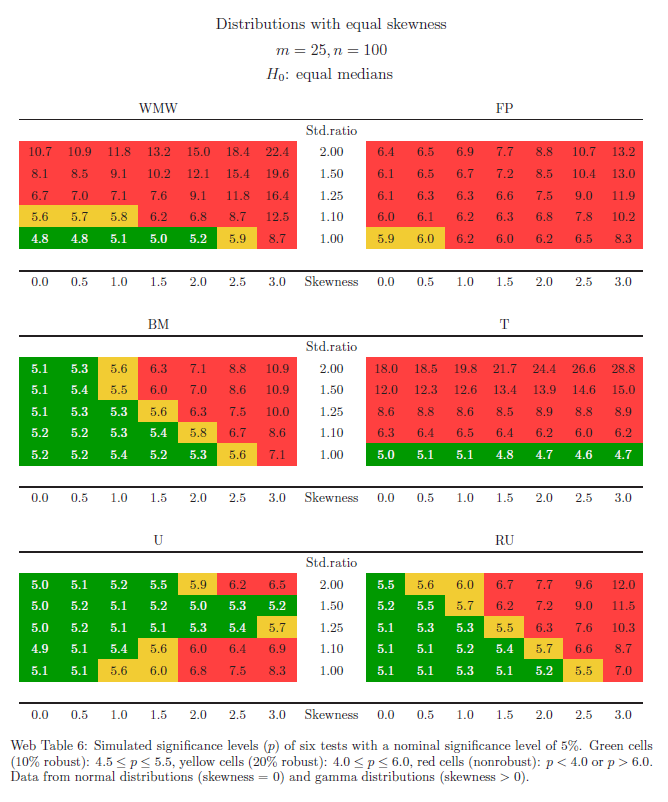

論文 Fagerland-Sandvik (2009) の Table 6 (上に引用)の結果は正しくないように思われる. 

このTable 6のWMWとBMの表におけるstd ratioが1.00の段の右端の値(それぞれ8.7と7.1)がおかしい.

歪度と標準偏差が等しい2つのガンマ分布は等しい.  ゆえにその場合には最初から中央値も等しい. その場合にはWMW検定の極めて強い帰無仮説の「2つの分布は等しい」が成立している場合である.  そのような場合に結果が歪度に依存するはずがない.  それにも関わらず, WMWの右下の値が8.7%と5%よりも結構大きな値になっているのはおかしい.

他のテーブルの数値も確認してみると, Table 8 にも同様の問題があり, 論文 Fagerland-Sandvik (2009) の equal median の場合の計算結果は信用できないように見える.

2つの分布の中央値を揃える計算の精度が低過ぎたのではないかと思われる.

以上の点について私が誤解しているならば詳しく教えて欲しい.

In [52]:
@time print_sim(; m=25, n=100, shifttype=:tie, list_skewness=list_skewness)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 25,  n = 100,  shifttype = tie

Wilcoxon-Mann-Whitney:
 10.7  10.7  10.8  10.8  11.1  11.0  10.9
  8.3   8.3   8.6   8.6   8.6   8.8   8.8
  6.6   6.8   6.7   6.9   7.0   7.1   7.0
  5.6   5.7   5.6   5.6   5.8   5.9   5.9
  4.9   5.0   4.8   4.9   4.8   4.9   4.9

Brunner-Munzel:
 5.1  5.0  5.1  5.1  5.1  5.3  5.2
 5.2  5.1  5.3  5.3  5.2  5.3  5.2
 5.1  5.2  5.1  5.3  5.2  5.1  5.1
 5.1  5.2  5.2  5.1  5.2  5.3  5.3
 5.2  5.3  5.1  5.2  5.1  5.2  5.1

Student t:
 17.9  19.4  23.5  29.3  35.6  41.4  44.0
 12.2  12.6  14.4  16.8  19.5  21.8  22.7
  8.5   8.7   9.0  10.1  10.8  11.8  11.9
  6.5   6.5   6.4   6.5   6.8   6.9   7.0
  5.0   5.1   4.9   4.9   4.8   4.8   4.7

Welch t:
 5.0  5.3  6.4  8.1  10.5  12.7  13.5
 5.1  5.1  5.5  5.9   6.5   7.0   6.7
 5.0  5.0  4.9  5.3   5.1   5.1   5.0
 5.0  5.0  5.0  5.1 

In [53]:
@time print_sim(; m=100, n=25, shifttype=:mean, list_skewness=list_skewness)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 100,  n = 25,  shifttype = mean

Wilcoxon-Mann-Whitney:
 1.5  2.3  5.2  12.5  26.4  47.7  70.9
 2.4  2.8  4.0   7.3  13.9  27.4  47.7
 3.3  3.5  3.9   5.0   7.5  13.3  25.3
 4.3  4.2  4.2   4.5   4.8   6.2  10.3
 5.0  4.8  4.9   4.9   4.8   5.0   4.8

Brunner-Munzel:
 5.0  6.7  13.1  27.0  47.9  70.9  88.3
 5.1  5.7   8.0  13.8  25.6  45.3  68.8
 5.1  5.3   6.1   7.8  12.1  22.1  40.4
 5.3  5.2   5.3   5.6   6.6   9.0  15.9
 5.2  5.0   5.2   5.2   5.2   5.3   5.1

Student t:
 0.4  0.5  0.6  0.6  0.8  1.0  1.2
 1.3  1.3  1.4  1.5  1.7  1.8  2.0
 2.5  2.5  2.6  2.6  2.7  2.7  2.7
 3.9  3.8  3.7  3.8  3.7  3.7  3.7
 5.0  4.9  5.0  4.9  4.8  4.8  4.6

Welch t:
 5.0  5.0  4.9  5.0  4.9  4.9  4.7
 4.9  4.9  5.0  5.2  5.3  5.4  5.5
 4.9  5.0  5.1  5.4  5.7  5.9  6.2
 5.1  5.1  5.2  5.7  5.9  6.3  6.9
 5.0  5.0  5.4  5.

In [54]:
@time print_sim(; m=100, n=25, shifttype=:median, list_skewness=list_skewness)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 100,  n = 25,  shifttype = median

Wilcoxon-Mann-Whitney:
 1.5  1.5  1.7  2.1  2.9  3.9  5.7
 2.5  2.5  2.5  2.8  3.3  4.2  5.9
 3.4  3.4  3.4  3.5  3.7  4.1  5.3
 4.2  4.1  4.2  4.1  4.2  4.2  4.4
 5.0  4.9  5.0  5.0  4.9  5.0  4.9

Brunner-Munzel:
 5.0  5.2  5.7  6.6  8.5  11.0  14.7
 5.2  5.1  5.4  6.0  7.1   9.0  12.4
 5.1  5.3  5.2  5.5  6.0   6.9   9.1
 5.2  5.1  5.2  5.2  5.4   5.7   6.4
 5.2  5.2  5.2  5.2  5.2   5.3   5.2

Student t:
 0.4  0.5  0.7  1.2  1.9  2.8  3.6
 1.4  1.4  1.5  1.8  2.0  2.3  2.4
 2.6  2.5  2.6  2.6  2.7  2.7  2.7
 3.8  3.7  3.8  3.7  3.7  3.6  3.5
 5.1  5.0  5.0  4.9  4.7  4.8  4.8

Welch t:
 5.0  6.1  9.4  15.1  21.9  28.3  33.9
 5.1  5.5  7.1   9.6  12.4  15.6  18.4
 5.0  5.3  6.0   7.3   9.0  10.3  12.0
 5.0  5.0  5.6   6.2   7.0   8.0   9.1
 5.1  5.1  5.3   5.7   6.1   6.8   

In [55]:
@time print_sim(; m=100, n=25, shifttype=:tie, list_skewness=list_skewness)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 100,  n = 25,  shifttype = tie

Wilcoxon-Mann-Whitney:
 1.5  1.5  1.5  1.6  1.5  1.6  1.6
 2.5  2.5  2.4  2.4  2.3  2.3  2.4
 3.4  3.5  3.3  3.2  3.3  3.2  3.2
 4.2  4.2  4.2  4.1  4.1  4.0  4.1
 4.9  4.8  4.8  4.8  4.8  4.9  4.8

Brunner-Munzel:
 5.2  5.1  5.2  5.3  5.2  5.1  5.1
 5.0  5.2  5.0  5.1  5.1  5.2  5.1
 5.1  5.3  5.0  5.1  5.2  5.2  5.0
 5.2  5.2  5.1  5.2  5.2  5.1  5.2
 5.3  5.1  5.1  5.2  5.1  5.2  5.1

Student t:
 0.5  0.6  1.4  3.0  5.8  9.0  11.0
 1.4  1.5  1.8  2.8  4.1  5.3   5.7
 2.5  2.7  2.8  3.1  3.5  3.8   3.6
 3.8  3.8  3.8  3.7  3.8  3.8   3.7
 5.0  5.0  4.8  5.0  4.7  4.8   4.6

Welch t:
 5.0  7.0  13.7  23.6  35.0  43.9  48.6
 4.9  6.0   8.7  13.5  19.1  23.9  26.7
 5.0  5.5   6.7   9.0  11.4  14.1  15.6
 5.0  5.3   5.8   6.7   8.0   9.2  10.3
 5.0  5.0   5.4   5.7   6.2   6.7   7.3

In [56]:
@time print_sim(; m=100, n=100, shifttype=:mean, list_skewness=list_skewness)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 100,  n = 100,  shifttype = mean

Wilcoxon-Mann-Whitney:
 5.9  9.0  19.8  39.4  64.4  84.9  95.4
 5.3  6.6  11.3  21.7  40.6  64.8  84.9
 5.1  5.4   7.1  10.9  19.9  37.5  61.2
 4.9  5.1   5.5   6.1   8.3  14.1  27.4
 5.0  4.9   4.9   5.1   5.1   5.0   5.0

Brunner-Munzel:
 5.0  7.9  17.6  36.0  60.2  81.4  93.5
 5.0  6.4  10.8  20.7  38.6  61.8  82.2
 5.1  5.4   7.1  10.8  19.5  36.2  58.8
 5.0  5.1   5.5   6.2   8.3  14.0  26.8
 5.1  5.0   4.9   5.2   5.1   5.1   5.1

Student t:
 5.0  5.1  5.1  5.3  5.4  5.5  5.8
 5.0  5.0  5.0  5.0  5.1  5.1  5.2
 5.0  4.9  5.0  5.0  5.0  5.0  5.0
 5.0  4.9  5.0  5.0  5.0  4.9  4.9
 5.0  5.0  4.9  5.1  5.0  4.9  4.9

Welch t:
 5.0  5.0  5.0  5.3  5.4  5.5  5.7
 5.0  5.0  5.0  5.0  5.1  5.1  5.2
 5.0  4.9  5.0  5.0  5.0  5.0  5.0
 5.0  4.9  5.0  5.0  5.0  4.8  4.8
 5.0  5.0  4

In [57]:
@time print_sim(; m=100, n=100, shifttype=:median, list_skewness=list_skewness)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 100,  n = 100,  shifttype = median

Wilcoxon-Mann-Whitney:
 5.9  6.1  7.0  8.8  12.1  16.4  21.9
 5.1  5.4  6.0  7.2   9.5  13.4  18.9
 5.0  5.2  5.4  5.9   7.0   9.5  13.6
 4.9  4.9  5.1  5.2   5.4   6.4   8.4
 5.0  5.1  5.0  4.8   5.0   5.0   4.9

Brunner-Munzel:
 5.1  5.2  6.0  7.7  10.4  14.0  18.9
 4.8  5.2  5.7  6.8   8.9  12.5  17.4
 5.0  5.1  5.3  5.9   6.9   9.3  13.1
 5.0  5.0  5.1  5.3   5.5   6.5   8.4
 5.1  5.2  5.0  4.9   5.1   5.1   5.0

Student t:
 5.2  6.3  10.1  16.9  25.4  34.4  41.2
 4.9  5.4   6.9   9.3  12.3  15.1  17.7
 4.9  5.2   5.7   6.3   6.9   8.2   8.7
 4.9  5.1   5.2   5.2   5.3   5.6   5.5
 5.1  5.1   5.0   4.9   4.9   5.0   4.8

Welch t:
 5.1  6.3  10.0  16.7  25.2  34.2  40.9
 4.9  5.4   6.9   9.3  12.3  15.0  17.6
 4.9  5.2   5.6   6.3   6.9   8.2   8.6
 4.9  5.1   5.2   5.2   5

In [58]:
@time print_sim(; m=100, n=100, shifttype=:tie, list_skewness=list_skewness)

skewness = ((0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0), (2.5, 2.5), (3.0, 3.0))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 100,  n = 100,  shifttype = tie

Wilcoxon-Mann-Whitney:
 5.8  5.9  5.8  6.0  5.9  6.1  6.0
 5.3  5.2  5.4  5.2  5.4  5.5  5.4
 5.1  5.1  5.0  5.2  5.1  5.2  5.2
 5.0  5.1  4.9  4.9  5.0  4.9  5.1
 5.1  5.0  4.9  5.0  4.9  5.1  4.9

Brunner-Munzel:
 5.0  5.0  5.0  5.1  5.0  5.1  5.0
 5.0  4.9  5.1  4.9  5.1  5.2  5.0
 5.0  5.1  4.9  5.1  5.0  5.1  5.1
 5.1  5.1  4.9  4.9  5.1  5.0  5.1
 5.1  5.1  5.0  5.1  5.0  5.1  5.0

Student t:
 5.0  7.8  16.3  30.6  46.9  59.6  65.8
 5.0  6.0   9.7  15.4  22.7  28.7  31.2
 4.9  5.4   6.5   8.4  10.7  12.8  13.5
 5.0  5.1   5.2   5.6   6.1   6.5   6.5
 5.1  5.0   5.0   5.0   4.8   4.9   4.9

Welch t:
 5.0  7.7  16.2  30.4  46.7  59.4  65.6
 5.0  6.0   9.7  15.3  22.6  28.5  31.1
 4.9  5.4   6.4   8.3  10.6  12.8  13.4
 5.0  5.1   5.2   5.6   6.0   6.4   6.5
 5.1  5.0   5.0   

In [59]:
@time print_sim(; m=25, n=25, shifttype=:mean, list_skewness=list_skewness2)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 25,  n = 25,  shifttype = mean

Wilcoxon-Mann-Whitney:
 9.0  13.5  20.8  31.5  44.4
 6.8   8.7  12.1  18.3  28.1
 5.7   6.4   7.1   8.5  12.2
 5.2   5.2   5.2   4.9   4.7
 4.9   4.8   4.7   5.0   6.4

Brunner-Munzel:
 8.4  12.7  19.2  28.8  40.2
 7.0   8.9  12.3  18.3  27.1
 6.0   6.8   7.6   9.0  13.0
 5.7   5.6   5.6   5.3   5.1
 5.4   5.3   5.1   5.4   6.7

Student t:
 5.5  5.8  6.2  6.7  7.1
 5.3  5.2  5.4  5.6  5.7
 5.0  5.2  5.1  5.0  5.0
 5.1  5.0  4.9  4.7  4.5
 5.0  4.9  4.7  4.6  4.4

Welch t:
 5.4  5.6  6.1  6.5  7.0
 5.2  5.1  5.2  5.4  5.5
 5.0  5.1  5.0  4.9  4.8
 5.0  4.9  4.8  4.6  4.3
 4.9  4.9  4.6  4.4  4.2

  3.582709 seconds (25.30 M allocations: 1.884 GiB, 7.44% gc time, 0.31% compilation time)


In [60]:
@time print_sim(; m=25, n=25, shifttype=:median, list_skewness=list_skewness2)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 25,  n = 25,  shifttype = median

Wilcoxon-Mann-Whitney:
 5.4  5.4  5.5  5.9  6.1
 5.0  4.9  4.9  4.9  5.5
 4.9  5.0  5.0  5.8  7.2
 5.0  5.0  5.6  6.6  8.6
 5.1  5.3  5.9  7.4  9.3

Brunner-Munzel:
 5.1  5.2  5.3  5.7  5.9
 5.3  5.2  5.2  5.3  6.0
 5.3  5.5  5.6  6.4  7.9
 5.6  5.5  6.2  7.2  9.2
 5.7  5.8  6.5  7.9  9.7

Student t:
 6.8  8.3  9.5  10.3  10.7
 6.3  6.7  7.1   7.3   7.1
 6.0  6.3  6.2   5.9   5.5
 5.9  5.6  5.7   5.4   4.9
 5.8  5.6  5.3   5.1   4.6

Welch t:
 6.5  7.8  8.9  9.7  10.0
 6.2  6.5  6.8  6.9   6.7
 5.9  6.2  6.0  5.7   5.2
 5.9  5.5  5.5  5.2   4.6
 5.7  5.5  5.2  4.9   4.4

  3.845765 seconds (25.47 M allocations: 1.933 GiB, 7.97% gc time)


In [61]:
@time print_sim(; m=25, n=25, shifttype=:tie, list_skewness=list_skewness2)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 25,  n = 25,  shifttype = tie

Wilcoxon-Mann-Whitney:
 5.5  5.4  5.4  5.3  5.3
 5.0  4.9  5.0  5.0  4.8
 4.8  4.9  4.8  4.8  4.8
 4.7  4.7  4.7  4.7  4.9
 4.7  4.8  4.8  5.0  5.0

Brunner-Munzel:
 5.2  5.1  5.1  5.2  5.3
 5.2  5.2  5.3  5.3  5.2
 5.2  5.4  5.2  5.2  5.2
 5.2  5.2  5.2  5.1  5.2
 5.2  5.2  5.2  5.4  5.3

Student t:
 6.9  8.7  10.9  12.7  13.3
 5.8  6.4   6.7   7.0   6.3
 5.4  5.6   5.5   5.1   4.6
 5.1  5.0   4.8   4.6   4.7
 5.1  4.9   4.9   4.9   5.2

Welch t:
 6.6  8.2  10.3  12.0  12.4
 5.7  6.2   6.5   6.7   5.9
 5.3  5.5   5.3   4.9   4.4
 5.0  4.9   4.6   4.4   4.4
 5.0  4.9   4.7   4.8   4.9

  3.325818 seconds (25.31 M allocations: 1.888 GiB, 7.22% gc time)


In [62]:
@time print_sim(; m=50, n=50, shifttype=:mean, list_skewness=list_skewness2)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 50,  n = 50,  shifttype = mean

Wilcoxon-Mann-Whitney:
 13.1  22.3  36.7  55.0  72.5
  8.8  12.8  20.3  33.1  50.4
  6.9   8.1   9.9  13.0  21.4
  5.9   5.9   5.7   5.3   5.2
  5.3   5.1   5.1   5.8   8.4

Brunner-Munzel:
 11.8  20.3  33.6  50.8  67.9
  8.6  12.5  19.7  31.9  47.9
  6.9   8.1   9.9  13.1  21.3
  6.0   6.0   5.7   5.4   5.2
  5.4   5.2   5.1   5.8   8.2

Student t:
 5.3  5.3  5.6  5.9  6.3
 5.1  5.1  5.3  5.3  5.4
 5.0  5.0  5.1  5.1  5.0
 5.1  5.1  4.9  4.9  4.9
 5.0  4.9  4.9  4.9  4.9

Welch t:
 5.2  5.2  5.5  5.8  6.2
 5.0  5.0  5.3  5.3  5.3
 5.0  5.0  5.1  5.0  4.9
 5.1  5.0  4.8  4.9  4.8
 5.0  4.9  4.9  4.9  4.8

  7.149826 seconds (25.62 M allocations: 1.975 GiB, 4.43% gc time)


In [63]:
@time print_sim(; m=50, n=50, shifttype=:median, list_skewness=list_skewness2)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 50,  n = 50,  shifttype = median

Wilcoxon-Mann-Whitney:
 5.7  5.9  6.0   6.5   7.2
 5.4  5.1  5.3   5.2   6.4
 5.3  5.4  5.8   7.2  10.4
 5.5  5.9  6.7   9.2  13.0
 5.4  6.2  7.4  10.2  14.7

Brunner-Munzel:
 5.0  5.2  5.4   5.9   6.6
 5.3  5.1  5.2   5.3   6.6
 5.4  5.6  6.0   7.5  10.7
 5.7  6.1  6.9   9.3  12.9
 5.6  6.3  7.6  10.2  14.3

Student t:
 10.4  14.2  18.3  21.9  23.3
  8.9  10.3  11.7  12.4  12.4
  7.7   8.5   8.6   8.4   7.9
  7.1   7.2   6.9   6.6   5.9
  6.4   6.4   6.1   5.6   5.2

Welch t:
 10.2  13.9  17.9  21.5  22.9
  8.8  10.2  11.5  12.3  12.2
  7.7   8.5   8.6   8.3   7.8
  7.0   7.2   6.9   6.6   5.8
  6.4   6.4   6.0   5.6   5.2

  7.144948 seconds (26.09 M allocations: 2.109 GiB, 3.91% gc time)


In [64]:
@time print_sim(; m=50, n=50, shifttype=:tie, list_skewness=list_skewness2)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 50,  n = 50,  shifttype = tie

Wilcoxon-Mann-Whitney:
 5.7  5.6  5.6  5.6  5.5
 5.1  5.2  5.2  5.1  5.2
 5.1  5.0  5.1  5.0  5.2
 4.9  4.9  5.0  5.0  5.1
 5.1  5.0  5.0  5.0  5.2

Brunner-Munzel:
 5.0  4.9  5.1  5.1  5.1
 5.0  5.1  5.2  5.1  5.2
 5.2  5.1  5.1  5.1  5.3
 5.0  5.1  5.1  5.1  5.1
 5.2  5.1  5.1  5.0  5.1

Student t:
 10.2  15.8  22.1  27.2  29.2
  7.5   9.3  10.8  11.1  10.4
  6.1   6.5   6.5   6.0   5.4
  5.5   5.3   5.1   4.8   4.7
  5.2   5.0   4.8   5.2   5.6

Welch t:
 9.9  15.6  21.8  26.8  28.7
 7.4   9.2  10.7  11.0  10.2
 6.1   6.4   6.5   5.9   5.3
 5.5   5.3   5.1   4.7   4.6
 5.2   5.0   4.8   5.1   5.5

  6.855213 seconds (25.73 M allocations: 2.008 GiB, 4.74% gc time)


In [65]:
@time print_sim(; m=25, n=100, shifttype=:mean, list_skewness=list_skewness2)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 25,  n = 100,  shifttype = mean

Wilcoxon-Mann-Whitney:
 16.2  23.5  34.2  47.3  60.7
 11.3  14.6  20.4  30.2  43.3
  7.9   8.8  10.2  13.3  20.7
  6.3   5.9   5.5   4.6   4.0
  4.8   4.5   3.8   3.8   4.9

Brunner-Munzel:
 8.7  13.4  20.6  30.5  41.7
 7.5   9.9  13.8  20.3  29.3
 6.4   7.3   8.5  10.7  15.4
 6.0   5.9   5.8   5.4   5.1
 5.5   5.4   5.0   5.6   7.9

Student t:
 17.8  18.2  18.1  18.5  18.6
 12.1  12.0  12.2  11.9  11.7
  8.5   8.4   8.3   8.1   7.9
  6.4   6.3   6.0   5.9   5.7
  5.0   4.9   4.6   4.6   4.6

Welch t:
 5.5  6.1  7.2  8.3  9.4
 5.5  6.1  7.0  8.0  8.6
 5.5  6.0  6.7  7.5  8.2
 5.5  5.9  6.4  7.0  7.8
 5.4  5.8  6.0  6.8  7.4

  7.381992 seconds (25.72 M allocations: 2.004 GiB, 4.70% gc time)


In [66]:
@time print_sim(; m=25, n=100, shifttype=:median, list_skewness=list_skewness2)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 25,  n = 100,  shifttype = median

Wilcoxon-Mann-Whitney:
 10.4  10.4  10.4  11.1  11.3
  8.0   7.7   7.3   6.9   6.6
  6.5   6.2   6.0   6.2   7.8
  5.6   5.5   5.4   6.5   8.6
  5.0   4.9   5.2   6.5   8.9

Brunner-Munzel:
 5.1  5.2  5.2  5.6   6.0
 5.2  5.2  5.2  5.3   5.9
 5.3  5.4  5.7  6.7   9.8
 5.5  5.8  6.5  8.5  12.4
 5.8  5.9  7.1  9.6  14.2

Student t:
 23.8  27.6  31.3  34.0  35.5
 16.0  17.6  18.7  19.1  19.1
 11.0  11.8  12.1  11.8  11.0
  8.4   8.4   8.1   7.6   7.2
  6.5   6.2   5.9   5.5   5.0

Welch t:
 6.7  7.5  8.3  9.0  8.9
 6.3  6.3  6.4  6.2  5.7
 5.8  5.7  5.6  5.2  5.1
 5.6  5.4  5.0  5.0  5.3
 5.5  5.1  5.0  5.3  5.9

  7.327180 seconds (25.93 M allocations: 2.062 GiB, 3.65% gc time)


In [67]:
@time print_sim(; m=25, n=100, shifttype=:tie, list_skewness=list_skewness2)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 25,  n = 100,  shifttype = tie

Wilcoxon-Mann-Whitney:
 10.4  10.4  10.0  9.7  9.5
  7.8   7.7   7.2  6.8  6.3
  6.3   6.0   5.7  5.2  4.7
  5.3   5.0   4.6  4.3  3.8
  4.6   4.2   4.0  3.7  3.4

Brunner-Munzel:
 5.1  5.2  5.1  5.2  5.4
 5.1  5.2  5.1  5.1  5.1
 5.2  5.1  5.2  5.2  5.1
 5.2  5.2  5.2  5.2  5.1
 5.2  5.1  5.2  5.1  5.1

Student t:
 23.4  29.2  34.5  38.5  40.1
 14.6  16.7  18.0  18.3  17.2
  9.6  10.0  10.0   9.4   8.8
  6.9   6.8   6.2   6.0   5.6
  5.3   4.9   4.8   4.6   4.7

Welch t:
 6.5  8.2  9.9  11.2  11.3
 5.5  6.0  6.1   5.7   5.4
 5.2  5.1  5.1   5.2   5.5
 5.1  5.2  5.4   6.4   7.6
 5.1  5.3  6.4   8.0  10.1

  7.521338 seconds (25.70 M allocations: 1.999 GiB, 4.51% gc time)


In [68]:
@time print_sim(; m=100, n=25, shifttype=:mean, list_skewness=list_skewness2)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 100,  n = 25,  shifttype = mean

Wilcoxon-Mann-Whitney:
 5.8  12.5  24.8  45.0  67.8
 4.9   7.7  12.9  22.7  39.7
 4.9   5.8   7.2   9.1  14.8
 4.9   5.5   5.5   5.8   6.1
 5.4   5.6   6.1   7.3  10.5

Brunner-Munzel:
 13.7  25.6  44.6  67.8  86.2
  8.9  13.2  21.3  36.5  58.7
  6.9   8.0   9.5  12.4  21.4
  5.7   6.2   5.9   5.5   5.2
  5.4   5.3   5.2   5.3   6.8

Student t:
 0.5  0.6  0.8  1.0  1.2
 1.4  1.5  1.7  1.8  1.9
 2.7  2.7  2.7  2.8  2.9
 3.8  4.0  3.9  3.9  4.0
 5.1  5.0  5.0  4.9  4.9

Welch t:
 5.0  4.9  4.9  4.8  4.8
 5.0  5.0  5.2  5.1  5.2
 5.1  5.1  5.3  5.8  5.9
 5.0  5.3  5.4  5.8  6.2
 5.2  5.2  5.6  6.0  6.8

  7.752271 seconds (25.32 M allocations: 1.889 GiB, 4.16% gc time)


In [69]:
@time print_sim(; m=100, n=25, shifttype=:median, list_skewness=list_skewness2)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 100,  n = 25,  shifttype = median

Wilcoxon-Mann-Whitney:
 1.6  1.7  1.8   2.1   2.6
 2.8  2.9  3.0   3.6   5.4
 4.0  4.4  5.2   7.2  10.9
 5.1  5.7  7.1   9.8  14.1
 5.9  6.6  8.5  11.5  16.0

Brunner-Munzel:
 5.0  5.2  5.5  5.8   6.7
 5.3  5.3  5.1  5.3   6.1
 5.4  5.5  5.8  6.7   8.5
 5.6  5.8  6.3  7.6   9.7
 5.6  5.8  6.6  8.0  10.3

Student t:
 1.6  2.5  3.8  4.9  5.4
 2.8  3.4  3.9  4.1  3.8
 4.1  4.4  4.5  4.2  3.7
 5.2  5.2  4.9  4.7  4.2
 6.4  6.1  5.8  5.4  5.0

Welch t:
 13.7  20.5  27.7  33.3  37.1
 10.4  13.8  16.9  19.5  20.9
  8.7  10.6  12.3  13.3  13.9
  7.8   8.9   9.5  10.1  10.4
  7.2   7.7   8.3   8.4   8.5

  7.648723 seconds (25.81 M allocations: 2.029 GiB, 3.43% gc time)


In [70]:
@time print_sim(; m=100, n=25, shifttype=:tie, list_skewness=list_skewness2)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 100,  n = 25,  shifttype = tie

Wilcoxon-Mann-Whitney:
 1.7  1.7  1.8  1.9  2.1
 2.7  2.7  3.0  3.3  3.6
 3.8  3.9  4.2  4.7  5.1
 4.6  4.9  5.3  5.8  6.3
 5.2  5.6  5.9  6.5  7.1

Brunner-Munzel:
 5.2  5.2  5.1  5.2  5.1
 5.2  5.1  5.1  5.2  5.2
 5.2  5.2  5.1  5.2  5.1
 5.3  5.2  5.3  5.2  5.2
 5.1  5.2  5.1  5.1  5.3

Student t:
 1.6  3.0  5.3  7.4  7.9
 2.3  2.9  3.5  3.5  2.9
 3.2  3.3  3.2  2.9  2.7
 4.2  4.1  4.0  3.8  3.8
 5.1  5.0  4.9  5.2  5.8

Welch t:
 13.4  22.6  32.3  39.7  42.7
  9.0  12.7  15.8  17.9  18.4
  6.9   8.4   9.3   9.6   9.6
  6.1   6.5   6.9   6.7   6.5
  5.6   5.7   5.6   5.4   5.4

  7.732276 seconds (25.49 M allocations: 1.938 GiB, 4.36% gc time)


In [71]:
@time print_sim(; m=100, n=100, shifttype=:mean, list_skewness=list_skewness2)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 100,  n = 100,  shifttype = mean

Wilcoxon-Mann-Whitney:
 20.4  38.7  62.2  83.1  94.6
 12.7  21.1  35.5  57.2  79.1
  8.7  11.0  14.7  21.3  37.7
  6.7   6.8   6.5   5.7   5.1
  5.8   5.3   5.0   6.2  11.8

Brunner-Munzel:
 18.5  35.9  58.9  80.2  92.9
 12.3  20.5  34.4  55.6  77.0
  8.7  11.0  14.6  21.2  37.3
  6.7   6.8   6.6   5.7   5.0
  5.8   5.3   5.0   6.2  11.5

Student t:
 5.3  5.3  5.3  5.5  5.8
 5.1  5.2  5.2  5.2  5.3
 4.9  5.0  5.1  5.1  5.1
 5.0  4.9  5.0  4.9  4.9
 5.0  5.0  4.9  4.9  5.0

Welch t:
 5.3  5.2  5.3  5.4  5.7
 5.1  5.2  5.2  5.2  5.3
 4.9  5.0  5.1  5.1  5.1
 5.0  4.9  5.0  4.9  4.9
 5.0  5.0  4.9  4.9  4.9

 21.462333 seconds (25.99 M allocations: 2.079 GiB, 1.36% gc time)


In [72]:
@time print_sim(; m=100, n=100, shifttype=:median, list_skewness=list_skewness2)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 100,  n = 100,  shifttype = median

Wilcoxon-Mann-Whitney:
 5.8  5.9  6.4   7.2   8.7
 5.5  5.3  5.2   5.5   7.9
 5.8  5.8  6.7   9.4  16.5
 5.9  6.5  8.6  13.0  21.4
 6.4  7.3  9.9  15.6  24.2

Brunner-Munzel:
 5.0  5.2  5.7   6.5   7.8
 5.3  5.2  5.1   5.5   8.0
 5.8  5.8  6.8   9.6  16.5
 6.0  6.6  8.8  13.0  21.0
 6.5  7.4  9.9  15.4  23.3

Student t:
 17.8  27.3  36.9  44.8  48.5
 13.9  17.7  21.2  23.2  23.5
 11.5  12.6  13.6  13.4  12.4
  9.5   9.8   9.6   8.7   7.7
  8.8   8.1   7.4   6.5   5.7

Welch t:
 17.7  27.1  36.7  44.6  48.2
 13.8  17.6  21.1  23.1  23.4
 11.4  12.6  13.6  13.4  12.4
  9.5   9.8   9.6   8.7   7.6
  8.8   8.0   7.4   6.5   5.7

 21.216221 seconds (27.09 M allocations: 2.390 GiB, 1.99% gc time)


In [73]:
@time print_sim(; m=100, n=100, shifttype=:tie, list_skewness=list_skewness2)

skewness = ((1.0, 0.5), (1.5, 1.0), (2.0, 1.5), (2.5, 2.0), (3.0, 2.5))
stdratio = (2.0, 1.5, 1.25, 1.1, 1.0)
distx = gammadist,  disty = gammadist, m = 100,  n = 100,  shifttype = tie

Wilcoxon-Mann-Whitney:
 5.7  5.9  5.6  5.6  5.4
 5.2  5.2  5.2  5.1  5.0
 5.1  5.0  5.0  5.1  5.0
 4.9  4.9  5.0  5.1  5.1
 4.9  5.0  5.2  5.2  5.3

Brunner-Munzel:
 5.0  5.2  5.1  5.0  4.9
 5.1  5.0  5.0  5.0  5.0
 5.1  5.1  5.0  5.1  5.0
 5.0  5.0  5.1  5.1  5.0
 5.0  5.0  5.2  5.1  5.1

Student t:
 17.5  30.0  44.3  54.5  57.8
 11.1  15.5  19.3  20.7  19.3
  7.7   8.7   8.8   7.9   6.9
  6.2   5.9   5.5   5.0   4.8
  5.5   5.1   5.1   5.5   6.4

Welch t:
 17.3  29.8  44.1  54.3  57.6
 11.0  15.4  19.2  20.6  19.2
  7.7   8.7   8.7   7.9   6.8
  6.2   5.9   5.5   4.9   4.7
  5.5   5.1   5.1   5.5   6.3

 21.318976 seconds (26.36 M allocations: 2.185 GiB, 1.73% gc time)


In [123]:
@time print_sim(gammadist(1.1, 3), gammadist(1, 3), 1000, 1000; shifttype=:mean, L=10^4)

distx = Gamma{Float64}(α=0.4444444444444444, θ=1.6500000000000001)
disty = Gamma{Float64}(α=0.4444444444444444, θ=1.5)
m = 1000,  n = 1000,  shifttype = mean

Wilcoxon-Mann-Whitney: 99.0%
Brunner-Munzel:        98.9%
Student t:             4.8%
Welch t:               4.8%

  6.516502 seconds (111.38 k allocations: 11.378 MiB)


In [119]:
@time print_sim(gammadist(1.1, 3), gammadist(1, 3), 1000, 1000; shifttype=:median, L=10^4)

distx = Gamma{Float64}(α=0.4444444444444444, θ=1.6500000000000001)
disty = Gamma{Float64}(α=0.4444444444444444, θ=1.5)
m = 1000,  n = 1000,  shifttype = median

Wilcoxon-Mann-Whitney: 39.8%
Brunner-Munzel:        39.5%
Student t:             13.2%
Welch t:               13.2%

  6.328204 seconds (123.66 k allocations: 12.553 MiB, 6.88% compilation time)


In [120]:
@time print_sim(gammadist(1.1, 3), gammadist(1, 3), 1000, 1000; shifttype=:tie, L=10^4)

distx = Gamma{Float64}(α=0.4444444444444444, θ=1.6500000000000001)
disty = Gamma{Float64}(α=0.4444444444444444, θ=1.5)
m = 1000,  n = 1000,  shifttype = tie

Wilcoxon-Mann-Whitney: 5.0%
Brunner-Munzel:        5.0%
Student t:             22.7%
Welch t:               22.7%

  6.347301 seconds (109.36 k allocations: 10.765 MiB)


In [121]:
@time print_sim(gammadist(2, 3), gammadist(1, 3), 1000, 1000; shifttype=:tie, L=10^4)

distx = Gamma{Float64}(α=0.4444444444444444, θ=3.0)
disty = Gamma{Float64}(α=0.4444444444444444, θ=1.5)
m = 1000,  n = 1000,  shifttype = tie

Wilcoxon-Mann-Whitney: 5.9%
Brunner-Munzel:        4.9%
Student t:             100.0%
Welch t:               100.0%

  6.369439 seconds (125.11 k allocations: 15.373 MiB)


In [122]:
@time print_sim(gammadist(5, 5), gammadist(1, 5), 1000, 1000; shifttype=:tie, L=10^4)

distx = Gamma{Float64}(α=0.16, θ=12.5)
disty = Gamma{Float64}(α=0.16, θ=2.5)
m = 1000,  n = 1000,  shifttype = tie

Wilcoxon-Mann-Whitney: 6.6%
Brunner-Munzel:        4.5%
Student t:             100.0%
Welch t:               100.0%

  6.444335 seconds (124.94 k allocations: 15.361 MiB)
